In [312]:
%run functions.ipynb

seed = 10
np.random.seed(seed)
tf.random.set_seed(seed)

## Generation of dataset

### Simulated data

In [10]:
# DATA

P=500   
J=5
real_K_=4
MoyLCM=0  
Mass0=1.2   
N_tableaux=1000 


# mean across 10 generations (since stochastic generation) is 0.76-0.8 with Moy=0 and Masso0=1, 
# ""                  ""  is 0.74 if Moy0=0 and Masso0 set to 1.25
# ""                  ""  with Mass0=1.5 we have 72%
# slightly lower than reach on Real dataset (which is around 0.85, fixing the demographic group)

# MoyLCM=1 and Mass0=1 is actually the more similar (mean is 0.85-0.9)

T, Types, theta, alpha_proportion, poids_0 = dataset_LCM(P, J, real_K_, MoyLCM, Mass0, N_tableaux)  # random poids in [0, 1]


[[0.64394051 1.02929117 0.68275723 0.73414941 1.10594978]
 [0.45102343 0.75182383 0.74257925 0.16585162 0.2361606 ]
 [0.08495596 1.19307218 0.3474426  0.84349875 0.38936   ]
 [0.74942087 0.10620686 1.02800953 0.04880523 1.06409484]] are the thresholds for sparsity 

[[1.93137196 1.6446268  1.77249032 1.89845666 0.41433354]
 [5.70612305 1.8280402  1.08542057 2.20788928 0.97374837]
 [0.71896927 0.62517203 0.98441207 0.16866025 1.09611884]
 [1.01274172 1.58021201 1.26402856 1.54602271 1.52426316]] are the parameters for the KxJ Poissons 



In [11]:
# GENERATION Regressors and Dependent

result, X, Y = preprocess_dataset(T)

print(f"\nMean of Reach across campaigns: {Y.mean(): .5f}\n")

pd.DataFrame(X)

Execution time for preprocessing the dataset  is  0.0  h : 0.0  m : 4.2  s

Mean of Reach across campaigns:  0.83065



,0,1,2,3,4
0,1.212,0.360,0.408,0.874,0.320
1,1.204,0.448,0.372,1.030,0.332
2,1.134,0.492,0.346,0.904,0.344
3,1.096,0.504,0.364,0.960,0.296
4,1.128,0.494,0.322,1.044,0.414
...,...,...,...,...,...
995,1.110,0.466,0.312,1.010,0.354
996,1.242,0.506,0.346,1.040,0.324
997,1.106,0.402,0.364,0.944,0.370
998,1.176,0.552,0.338,0.940,0.354


### Linear models

In [12]:
# 100-fold Cross-validation

spl = 100
kf = KFold(n_splits=spl, shuffle=True)

#kf = LeaveOneOut()

r2, rmse = [], []
tot_interc, tot_slopes = [], []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    lr = LinearRegression().fit(X_train, Y_train)
    preds = lr.predict(X_test)
    
    r2.append(r2_score(Y_test, preds))
    rmse.append(np.sqrt(mean_squared_error(Y_test, preds)))
    
    tot_slopes.append(lr.coef_)
    tot_interc.append(lr.intercept_)
    
avg_interc = np.array(tot_interc).mean()

tot_slopes = np.reshape(tot_slopes, (spl, X_train.shape[1]))
avg_slopes = tot_slopes.mean(axis=0)

# averaged score
avg_r2 = np.array(r2).mean()
median_r2 = np.median(r2)

avg_rmse = np.array(rmse).mean()
median_rmse = np.median(rmse)

print(f"\t \t AVG. ACROSS {spl} SPLITS\n")
print(f"Estimated intercept: {avg_interc}")
print(f"Estimated slopes: {avg_slopes}", "\n")

print(f"Average R2 score on holdout sample: {avg_r2: .5%}")
print(f"Median R2 score on holdout sample: {median_r2: .5%}\n")
print(f"Std. deviation of R2 scores on holdout sample: {np.std(np.array(r2))}\n")

print(f"Average RMSE on holdout sample: {avg_rmse}")
print(f"Median RMSE on holdout sample: {median_rmse}\n")


	 	 AVG. ACROSS 100 SPLITS

Estimated intercept: 0.6006478952332014
Estimated slopes: [0.03284527 0.08857629 0.11866783 0.07168537 0.10380474] 

Average R2 score on holdout sample:  2.44608%
Median R2 score on holdout sample:  14.42264%

Std. deviation of R2 scores on holdout sample: 0.5169902672276678

Average RMSE on holdout sample: 0.014428541628159678
Median RMSE on holdout sample: 0.014298409002295133



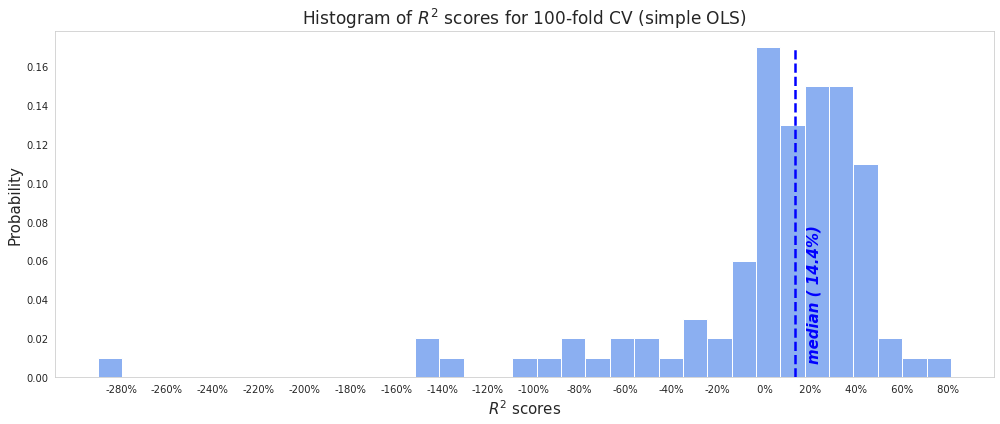

In [21]:
r2_first = np.array(r2)
first_bound = r2_first.min()-0.1
second_bound = r2_first.max()+0.2
x_t_first = np.arange(first_bound, second_bound, 0.2)

fig, ax = plt.subplots(1, 1, figsize=(14, 6))
sns.histplot(r2, stat='probability', bins=35, color='cornflowerblue')

ax.set_title(f'Histogram of $R^2$ scores for {spl}-fold CV (simple OLS)', fontsize=17)

ax.set_xticks(x_t_first)
ax.set_xticklabels([f"{x: .0%}" if x not in [x_t_first[0], x_t_first[-1]] else "" for x in x_t_first])
ax.set_xlabel(r'$R^2$ scores', fontsize=15)
ax.set_ylabel(r'Probability', fontsize=15)

ax.grid(False)

plt.axvline(median_r2, 0, 0.95, color='blue', linewidth=2.5, linestyle='--')
plt.text(median_r2+0.05, 0.05*ax.get_ylim()[1], f'median ({median_r2: .1%})', rotation=90, color='blue', 
         fontstyle='oblique', fontweight='heavy', fontsize=15)

plt.tight_layout()
fig.savefig('images/OLS_CV.jpg', bbox_inches='tight', dpi=300)
plt.show()



In [26]:
# 100-fold Cross-validation WITH BOOTSTRAP

spl = 100
kf = KFold(n_splits=spl, shuffle=True)
n_boots = 500

r2, rmse = [], []
tot_interc, tot_slopes = [], []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    X_train = pd.DataFrame(data=X_train, columns=['X' + str(i+1) for i in range(J)])
    Y_train = pd.DataFrame(data=Y_train, columns=['Y'])
    data = pd.concat([X_train, Y_train], axis=1)
    
    boot_interc, boot_slopes = [], []
    
    for _ in range(n_boots):  
        # sample the rows, same size, with replacement out of the training data (1000 times)
        sample_data = data.sample(frac=1, replace=True)
        # fit a linear regression
        Y_tr_boot = sample_data.loc[:, 'Y']
        X_tr_boot = sample_data.loc[:, [p for p in data.columns if p != 'Y']]

        mod = LinearRegression()
        mod.fit(X_tr_boot, Y_tr_boot)

        boot_interc.append(mod.intercept_)
        boot_slopes.append(mod.coef_)
    
    avg_interc = np.array(boot_interc).mean()
    tot_interc.append(avg_interc)
    
    boot_slopes = np.reshape(boot_slopes, (n_boots, X_tr_boot.shape[1]))
    avg_slopes = boot_slopes.mean(axis=0)
    tot_slopes.append(avg_slopes)
    
    preds = avg_interc + np.matmul(X_test, avg_slopes)
    r2.append(r2_score(Y_test, preds))
    rmse.append(np.sqrt(mean_squared_error(Y_test, preds)))
    
final_interc = np.array(tot_interc).mean()

tot_slopes = np.reshape(tot_slopes, (spl, X_train.shape[1]))
final_slopes = tot_slopes.mean(axis=0)

# averaged score
avg_r2 = np.array(r2).mean()
median_r2 = np.median(r2)

avg_rmse = np.array(rmse).mean()
median_rmse = np.median(rmse)

print(f"\t AVG. ACROSS {spl} SPLITS (WITH {n_boots} BOOT SAMPLES FOR EACH)\n")
print(f"Estimated intercept: {final_interc}")
print(f"Estimated slopes: {final_slopes}", "\n")

print(f"Average R2 score on holdout sample: {avg_r2: .5%}")
print(f"Median R2 score on holdout sample: {median_r2: .5%}\n")
print(f"Std. deviation of R2 scores on holdout sample: {np.std(np.array(r2))}\n")

print(f"Average RMSE on holdout sample: {avg_rmse}")
print(f"Median RMSE on holdout sample: {median_rmse}")



	 AVG. ACROSS 100 SPLITS (WITH 500 BOOT SAMPLES FOR EACH)

Estimated intercept: 0.6005426818040198
Estimated slopes: [0.03286096 0.08858578 0.11881912 0.07172795 0.10375796] 

Average R2 score on holdout sample:  11.78167%
Median R2 score on holdout sample:  16.00163%

Std. deviation of R2 scores on holdout sample: 0.30354617398608685

Average RMSE on holdout sample: 0.014426048550145634
Median RMSE on holdout sample: 0.014308600493407382


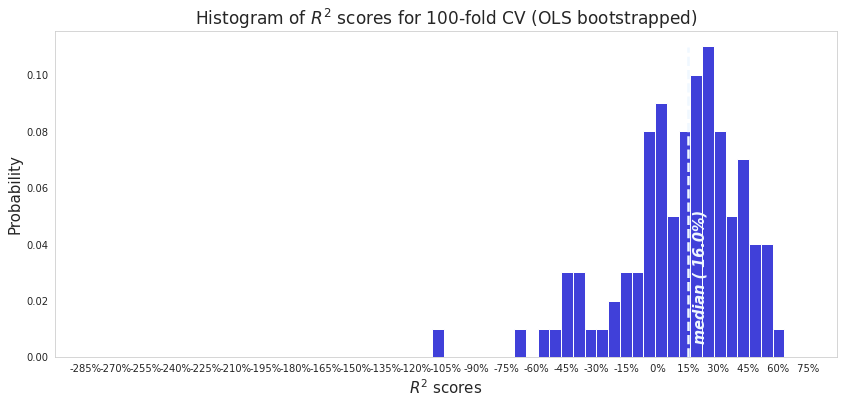

In [32]:
r2 = np.array(r2)
first = r2.min() if r2.min()<first_bound else first_bound
second = r2.max() if r2.max()>second_bound else second_bound

x_t = np.arange(first, second, 0.15)

fig, ax = plt.subplots(1, 1, figsize=(14, 6))
sns.histplot(r2, stat='probability', bins=30, color='mediumblue')

ax.set_title(f'Histogram of $R^2$ scores for {spl}-fold CV (OLS bootstrapped)', fontsize=17)

ax.set_xticks(x_t)
ax.set_xticklabels([f"{x: .0%}" if x not in [x_t[0], x_t[-1]] else "" for x in x_t])
ax.set_xlabel(r'$R^2$ scores', fontsize=15)
ax.set_ylabel(r'Probability', fontsize=15)

ax.grid(False)

plt.axvline(median_r2, 0, 0.95, color='aliceblue', linewidth=2.5, linestyle='--')
plt.text(median_r2+0.025, 0.05*ax.get_ylim()[1], f'median ({median_r2: .1%})', rotation=90, color='aliceblue', 
         fontstyle='oblique', fontweight='heavy', fontsize=14.5)

plt.savefig('images/OLS_bootstrap.jpg', bbox_inches='tight', dpi=300)
plt.show()


In [562]:
# 100-fold Cross-validation, PCA + FEATURE ENGINEERING (POLYNOMIAL FEATURES)

spl = 100
kf = KFold(n_splits=spl, shuffle=True)

#kf = LeaveOneOut()

perc_variance_explained = np.arange(0.5, 1, step=0.1)

tot_avg_components = []
tot_avg_intercept = []
tot_avg_slopes = []
tot_r2 = []
tot_rmse = []
to_plot = []

for i, spec_variance in enumerate(perc_variance_explained.tolist()):
    
    r2, rmse = [], []
    tot_interc, tot_slopes = [], []
    n_components = []

    steps=[('Poly', PolynomialFeatures(degree=3, include_bias=False)), ('Scaler', StandardScaler()), 
           ('PCA', PCA(n_components=spec_variance)), ('Linear', LinearRegression())]
    # from 5 to 56 features, then X is standardized, then PCA and components are selected such that they explain >0.85 of variance
    
    pipeline=Pipeline(steps)

    for train_index, test_index in kf.split(X):    

        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        lr = pipeline.fit(X_train, Y_train)
        preds = lr.predict(X_test)

        n_components.append(lr.named_steps['PCA'].n_components_)

        r2.append(r2_score(Y_test, preds))
        rmse.append(np.sqrt(mean_squared_error(Y_test, preds)))

        tot_slopes.append(lr.named_steps['Linear'].coef_[0])
        tot_interc.append(lr.named_steps['Linear'].intercept_)

    to_plot.append(r2)

    n_components = np.array(n_components)
    avg_components = int(n_components.mean())
    tot_avg_components.append(avg_components)

    avg_interc=np.array(tot_interc).mean()
    tot_avg_intercept.append(avg_interc)

    tot_slopes = np.reshape(tot_slopes, (spl, n_components[-1]))
    avg_slopes = tot_slopes.mean(axis=0)
    tot_avg_slopes.append(avg_slopes)

    # averaged score
    avg_r2 = np.array(r2).mean()
    median_r2 = np.median(r2)
    tot_r2.append([avg_r2, median_r2])

    avg_rmse = np.array(rmse).mean()
    median_rmse = np.median(rmse)
    tot_rmse.append([avg_rmse, median_rmse])
    
    if i==0:
        best_r2 = avg_r2
        best_idx = 0
    if avg_r2>best_r2:
        best_r2 = avg_r2
        best_idx = i

print(f"\t \t AVG. ACROSS {spl} SPLITS (with Polynomial Features and PCA)\n")
print(f"Best choice for the n. of components: those that explain more than{perc_variance_explained[best_idx]: .2%} of variance, on average {tot_avg_components[best_idx]}\n")
print(f"Estimated intercept: {tot_avg_intercept[best_idx]}")
print(f"Estimated slopes: {tot_avg_slopes[best_idx]}", "\n")

print(f"Average R2 score on holdout sample: {tot_r2[best_idx][0]: .5%}")
print(f"Median R2 score on holdout sample: {tot_r2[best_idx][1]: .5%}\n")
print(f"Std. deviation of R2 scores on holdout sample: {np.std(to_plot[best_idx]): .5f}\n")

print(f"Average RMSE on holdout sample: {tot_rmse[best_idx][0]: .5f}")
print(f"Median RMSE on holdout sample: {tot_rmse[best_idx][1]: .5f}\n")


	 	 AVG. ACROSS 100 SPLITS (with Polynomial Features and PCA)

Best choice for the n. of components: those that explain more than 90.00% of variance, on average 4

Estimated intercept: 0.8928760000000006
Estimated slopes: [ 0.00049705 -0.00081042 -0.00168378  0.00047107] 

Average R2 score on holdout sample:  8.82594%
Median R2 score on holdout sample:  19.13552%

Std. deviation of R2 scores on holdout sample:  0.36008

Average RMSE on holdout sample:  0.01220
Median RMSE on holdout sample:  0.01190



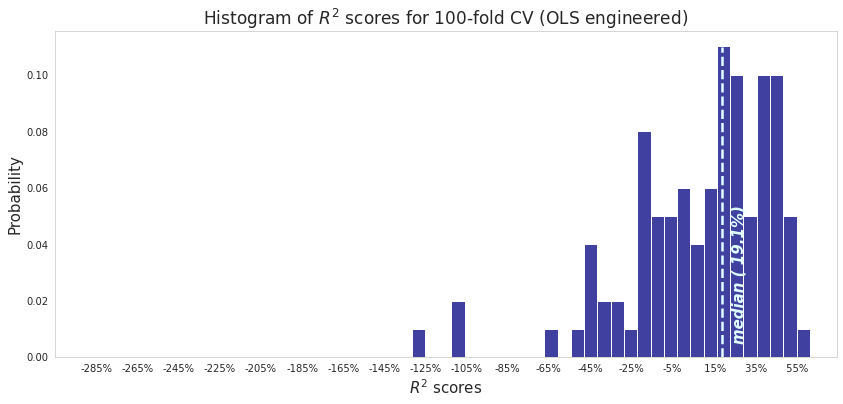

In [568]:
r2 = np.array(to_plot[best_idx])
first = r2.min() if r2.min()<first_bound else first_bound
second = r2.max() if r2.max()>second_bound else second_bound

x_t = np.arange(first, second, 0.2)

fig, ax = plt.subplots(1, 1, figsize=(14, 6))
sns.histplot(r2, stat='probability', bins=30, color='navy')

ax.set_title(f'Histogram of $R^2$ scores for {spl}-fold CV (OLS engineered)', fontsize=17)

ax.set_xticks(x_t)
ax.set_xticklabels([f"{x: .0%}" if x not in [x_t[0], x_t[-1]] else "" for x in x_t])
ax.set_xlabel(r'$R^2$ scores', fontsize=15)
ax.set_ylabel(r'Probability', fontsize=15)

ax.grid(False)

plt.axvline(tot_r2[best_idx][1], 0, 0.95, color='lightcyan', linewidth=2.5, linestyle='--')
plt.text(tot_r2[best_idx][1]+0.048, 0.05*ax.get_ylim()[1], f'median ({tot_r2[best_idx][1]: .1%})', rotation=90, color='lightcyan', 
         fontstyle='oblique', fontweight='heavy', fontsize=15)

plt.savefig('images/OLS_engineered.jpg', bbox_inches='tight', dpi=300)
plt.show()


### Ridge Regression

In [42]:
# GRID

np.logspace(-4, 1, 100)

array([1.00000000e-04, 1.12332403e-04, 1.26185688e-04, 1.41747416e-04,
       1.59228279e-04, 1.78864953e-04, 2.00923300e-04, 2.25701972e-04,
       2.53536449e-04, 2.84803587e-04, 3.19926714e-04, 3.59381366e-04,
       4.03701726e-04, 4.53487851e-04, 5.09413801e-04, 5.72236766e-04,
       6.42807312e-04, 7.22080902e-04, 8.11130831e-04, 9.11162756e-04,
       1.02353102e-03, 1.14975700e-03, 1.29154967e-03, 1.45082878e-03,
       1.62975083e-03, 1.83073828e-03, 2.05651231e-03, 2.31012970e-03,
       2.59502421e-03, 2.91505306e-03, 3.27454916e-03, 3.67837977e-03,
       4.13201240e-03, 4.64158883e-03, 5.21400829e-03, 5.85702082e-03,
       6.57933225e-03, 7.39072203e-03, 8.30217568e-03, 9.32603347e-03,
       1.04761575e-02, 1.17681195e-02, 1.32194115e-02, 1.48496826e-02,
       1.66810054e-02, 1.87381742e-02, 2.10490414e-02, 2.36448941e-02,
       2.65608778e-02, 2.98364724e-02, 3.35160265e-02, 3.76493581e-02,
       4.22924287e-02, 4.75081016e-02, 5.33669923e-02, 5.99484250e-02,
      

In [43]:
# Ridge regression with auto-optimization of penalization parameter over a Grid

spl = 100

alpha_grid = np.logspace(-4, 1, 100)  # 100 observations from 1e-4 until 10

mod = RidgeCV(alphas=alpha_grid, fit_intercept=True, scoring='r2', cv=spl).fit(X, Y)  # 100-fold CV
chosen = mod.alpha_

# to obtain RMSe on training, but need scoring=None
#grid = mod.cv_values_
#grid = np.reshape(grid, (X.shape[0], len(alpha_grid)))
#idx = alpha_grid.tolist().index(chosen)
#mse = grid[:, idx].mean()

print(f"\n \t CHOICE OF L2 parameter (across {spl} splits) \n")
print(f"Chosen alpha parameter: \t \t {chosen}")
print(f"Avg. R2 score on training data: \t {mod.best_score_: .5%}\n")
                


 	 CHOICE OF L2 parameter (across 100 splits) 

Chosen alpha parameter: 	 	 0.271858824273294
Avg. R2 score on training data: 	  12.12247%



In [46]:
# 100-fold Cross-validation, fixing value of optimized alpha

spl = 100
kf = KFold(n_splits=spl, shuffle=True)
#kf = LeaveOneOut()

r2, rmse = [], []
tot_interc, tot_slopes = [], []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    mod = Ridge(alpha=chosen, fit_intercept=True, tol=1e-5).fit(X_train, Y_train)
    preds = mod.predict(X_test)
    
    r2.append(r2_score(Y_test, preds))
    rmse.append(np.sqrt(mean_squared_error(Y_test, preds)))
    
    tot_slopes.append(mod.coef_)
    tot_interc.append(mod.intercept_)
    
avg_interc = np.array(tot_interc).mean()

tot_slopes = np.reshape(tot_slopes, (spl, X_train.shape[1]))
avg_slopes = tot_slopes.mean(axis=0)

# averaged score
avg_r2 = np.array(r2).mean()
median_r2 = np.median(r2)

avg_rmse = np.array(rmse).mean()
median_rmse = np.median(rmse)

print(f"\t \t AVG. ACROSS {spl} SPLITS\n")
print(f"Estimated intercept: {avg_interc}")
print(f"Estimated slopes: {avg_slopes}", "\n")

print(f"Average R2 score on holdout sample: {avg_r2: .5%}")
print(f"Median R2 score on holdout sample: {median_r2: .5%}\n")
print(f"Std. deviation of R2 scores on holdout sample: {np.std(np.array(r2))}\n")

print(f"Average RMSE on holdout sample: {avg_rmse}")
print(f"Median RMSE on holdout sample: {median_rmse}")


	 	 AVG. ACROSS 100 SPLITS

Estimated intercept: 0.6284994318501215
Estimated slopes: [0.03307319 0.07548698 0.09605191 0.06535318 0.08256937] 

Average R2 score on holdout sample:  9.53831%
Median R2 score on holdout sample:  14.76212%

Std. deviation of R2 scores on holdout sample: 0.3369544111636528

Average RMSE on holdout sample: 0.014484417802877682
Median RMSE on holdout sample: 0.014191295181833478


In [47]:
pen = chosen*(np.square(avg_slopes).sum())
print(f"The amount of L2 penalization (averaged across the splits) is: {pen}")

The amount of L2 penalization is: 0.007369229957510539


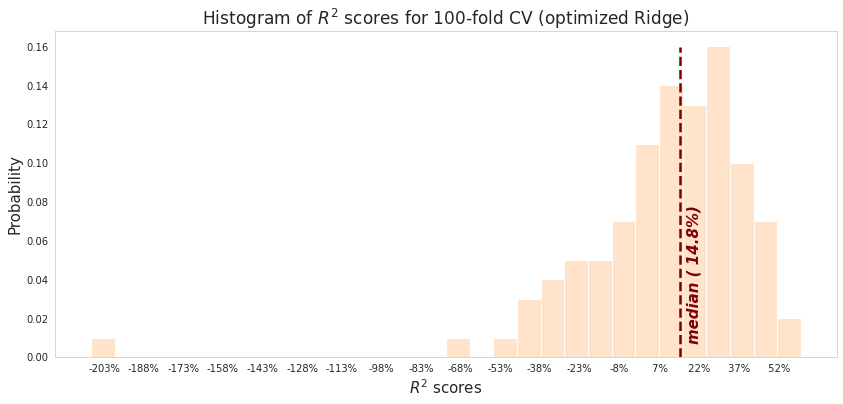

In [49]:
r2_first = np.array(r2)
first_bound = r2_first.min()-0.1
second_bound = r2_first.max()+0.2
x_t_first = np.arange(first_bound, second_bound, 0.15)

fig, ax = plt.subplots(1, 1, figsize=(14, 6))
sns.histplot(r2, stat='probability', bins=30, color='peachpuff')

ax.set_title(f'Histogram of $R^2$ scores for {spl}-fold CV (optimized Ridge)', fontsize=17)

ax.set_xticks(x_t_first)
ax.set_xticklabels([f"{x: .0%}" if x not in [x_t_first[0], x_t_first[-1]] else "" for x in x_t_first])
ax.set_xlabel(r'$R^2$ scores', fontsize=15)
ax.set_ylabel(r'Probability', fontsize=15)

ax.grid(False)

plt.axvline(median_r2, 0, 0.95, color='maroon', linewidth=2.5, linestyle='--')
plt.text(median_r2+0.023, 0.05*ax.get_ylim()[1], f'median ({median_r2: .1%})', rotation=90, color='maroon', 
         fontstyle='oblique', fontweight='heavy', fontsize=15)

plt.savefig('images/Ridge_CV.jpg', bbox_inches='tight', dpi=300)
plt.show()


In [50]:
# Ridge regression - 100-fold Cross-validation WITH BOOTSTRAP (after auto-tuning)

# find with CV validation the optimized parameter, then average across different bootstrapped samples

spl = 100
kf = KFold(n_splits=spl, shuffle=True)
n_boots = 500

r2, rmse = [], []
tot_interc, tot_slopes = [], []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    X_train = pd.DataFrame(data=X_train, columns=['X' + str(i+1) for i in range(J)])
    Y_train = pd.DataFrame(data=Y_train, columns=['Y'])
    data = pd.concat([X_train, Y_train], axis=1)
    
    boot_interc, boot_slopes = [], []
    
    for _ in range(n_boots):  
        # sample the rows, same size, with replacement out of the training data (1000 times)
        sample_data = data.sample(frac=1, replace=True)
        # fit a linear regression
        Y_tr_boot = sample_data.loc[:, 'Y']
        X_tr_boot = sample_data.loc[:, [p for p in data.columns if p != 'Y']]
        
         # not anymore CV, using previously found alpha
        mod = Ridge(alpha=chosen, fit_intercept=True, tol=1e-5) 
        mod.fit(X_tr_boot, Y_tr_boot)

        boot_interc.append(mod.intercept_)
        boot_slopes.append(mod.coef_)
    
    avg_interc = np.array(boot_interc).mean()
    tot_interc.append(avg_interc)
    
    boot_slopes = np.reshape(boot_slopes, (n_boots, X_tr_boot.shape[1]))
    avg_slopes = boot_slopes.mean(axis=0)
    tot_slopes.append(avg_slopes)
    
    preds = avg_interc + np.matmul(X_test, avg_slopes)
    r2.append(r2_score(Y_test, preds))
    rmse.append(np.sqrt(mean_squared_error(Y_test, preds)))
    
final_interc = np.array(tot_interc).mean()

tot_slopes = np.reshape(tot_slopes, (spl, X_train.shape[1]))
final_slopes = tot_slopes.mean(axis=0)

# averaged score
avg_r2 = np.array(r2).mean()
median_r2 = np.median(r2)

avg_rmse = np.array(rmse).mean()
median_rmse = np.median(rmse)

print(f"\t AVG. ACROSS {spl} SPLITS (WITH {n_boots} BOOT SAMPLES FOR EACH)\n")
print(f"Estimated intercept: {final_interc}")
print(f"Estimated slopes: {final_slopes}", "\n")

print(f"Average R2 score on holdout sample: {avg_r2: .5%}")
print(f"Median R2 score on holdout sample: {median_r2: .5%}\n")
print(f"Std. deviation of R2 scores on holdout sample: {np.std(np.array(r2)): .5f}\n")

print(f"Average RMSE on holdout sample: {avg_rmse: .5f}")
print(f"Median RMSE on holdout sample: {median_rmse: .5f}")


	 AVG. ACROSS 100 SPLITS (WITH 500 BOOT SAMPLES FOR EACH)

Estimated intercept: 0.6286874946692201
Estimated slopes: [0.03302832 0.0754349  0.09586159 0.0653766  0.08239255] 

Average R2 score on holdout sample:  9.97005%
Median R2 score on holdout sample:  18.03304%

Std. deviation of R2 scores on holdout sample: 0.3458880114591881

Average RMSE on holdout sample: 0.014363750602907434
Median RMSE on holdout sample: 0.014395997639267978


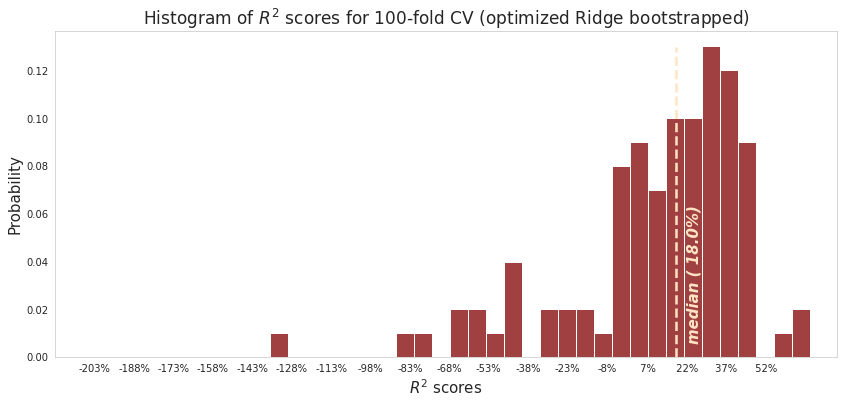

In [56]:
r2 = np.array(r2)
first = r2.min() if r2.min()<first_bound else first_bound
second = r2.max() if r2.max()>second_bound else second_bound

x_t = np.arange(first, second, 0.15)

fig, ax = plt.subplots(1, 1, figsize=(14, 6))
sns.histplot(r2, stat='probability', bins=30, color='maroon')

ax.set_title(f'Histogram of $R^2$ scores for {spl}-fold CV (optimized Ridge bootstrapped)', fontsize=17)

ax.set_xticks(x_t)
ax.set_xticklabels([f"{x: .0%}" if x not in [x_t[0], x_t[-1]] else "" for x in x_t])
ax.set_xlabel(r'$R^2$ scores', fontsize=15)
ax.set_ylabel(r'Probability', fontsize=15)

ax.grid(False)

plt.axvline(median_r2, 0, 0.95, color='bisque', linewidth=2.5, linestyle='--')
plt.text(median_r2+0.037, 0.05*ax.get_ylim()[1], f'median ({median_r2: .1%})', rotation=90, color='bisque', 
         fontstyle='oblique', fontweight='heavy', fontsize=15)

plt.savefig('images/Ridge_bootstrap.jpg', bbox_inches='tight', dpi=300)
plt.show()


In [578]:
# 100-fold Cross-validation, PCA + FEATURE ENGINEERING (POLYNOMIAL FEATURES)

spl = 100
kf = KFold(n_splits=spl, shuffle=True)

perc_variance_explained = np.arange(0.5, 1, step=0.1)

tot_avg_components = []
tot_avg_intercept = []
tot_avg_slopes = []
tot_r2 = []
tot_rmse = []
r2_fin = []

for i, spec_variance in enumerate(perc_variance_explained.tolist()):
    
    r2, rmse = [], []
    tot_interc, tot_slopes = [], []
    n_components = []

    steps=[('Poly', PolynomialFeatures(degree=3, include_bias=False)), ('Scaler', StandardScaler()), 
           ('PCA', PCA(n_components=spec_variance)), ('Ridge', Ridge(alpha=chosen, fit_intercept=True, tol=1e-5))]
    # from 5 to 56 features, then X is standardized, then PCA and components are selected such that they explain >0.85 of variance
    
    pipeline=Pipeline(steps)

    for train_index, test_index in kf.split(X):            

        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        lr = pipeline.fit(X_train, Y_train)
        preds = lr.predict(X_test)

        n_components.append(lr.named_steps['PCA'].n_components_)

        r2.append(r2_score(Y_test, preds))
        rmse.append(np.sqrt(mean_squared_error(Y_test, preds)))

        tot_slopes.append(lr.named_steps['Ridge'].coef_)
        tot_interc.append(lr.named_steps['Ridge'].coef_)
        
    r2_fin.append(r2)

    n_components = np.array(n_components)
    avg_components = int(n_components.mean())
    tot_avg_components.append(avg_components)

    avg_interc=np.array(tot_interc).mean()
    tot_avg_intercept.append(avg_interc)

    tot_slopes = np.reshape(tot_slopes, (spl, n_components[-1]))
    avg_slopes = tot_slopes.mean(axis=0)
    tot_avg_slopes.append(avg_slopes)

    # averaged score
    avg_r2 = np.array(r2).mean()
    median_r2 = np.median(r2)
    tot_r2.append([avg_r2, median_r2])

    avg_rmse = np.array(rmse).mean()
    median_rmse = np.median(rmse)
    tot_rmse.append([avg_rmse, median_rmse])
    
    if i==0:
        best_r2 = avg_r2
        best_idx = 0
    if avg_r2>best_r2:
        best_r2 = avg_r2
        best_idx = i

print(f"\t \t AVG. ACROSS {spl} SPLITS (with Polynomial Features and PCA)\n")
print(f"Best choice for the n. of components: those that explain more than{perc_variance_explained[best_idx]: .2%} of variance, on average {tot_avg_components[best_idx]}\n")
print(f"Estimated intercept: {tot_avg_intercept[best_idx]}")
print(f"Estimated slopes: {tot_avg_slopes[best_idx]}", "\n")

print(f"Average R2 score on holdout sample: {tot_r2[best_idx][0]: .5%}")
print(f"Median R2 score on holdout sample: {tot_r2[best_idx][1]: .5%}\n")
print(f"Std. deviation of R2 scores on holdout sample: {np.std(r2_fin[best_idx]): .5f}\n")

print(f"Average RMSE on holdout sample: {tot_rmse[best_idx][0]}")
print(f"Median RMSE on holdout sample: {tot_rmse[best_idx][1]}\n")



	 	 AVG. ACROSS 100 SPLITS (with Polynomial Features and PCA)

Best choice for the n. of components: those that explain more than 90.00% of variance, on average 4

Estimated intercept: -0.00041045718496907123
Estimated slopes: [ 0.00049706 -0.00081095 -0.0017997   0.00047175] 

Average R2 score on holdout sample:  11.21838%
Median R2 score on holdout sample:  19.07457%

Std. deviation of R2 scores on holdout sample:  0.31907

Average RMSE on holdout sample: 0.012211706715269388
Median RMSE on holdout sample: 0.012205384980065341



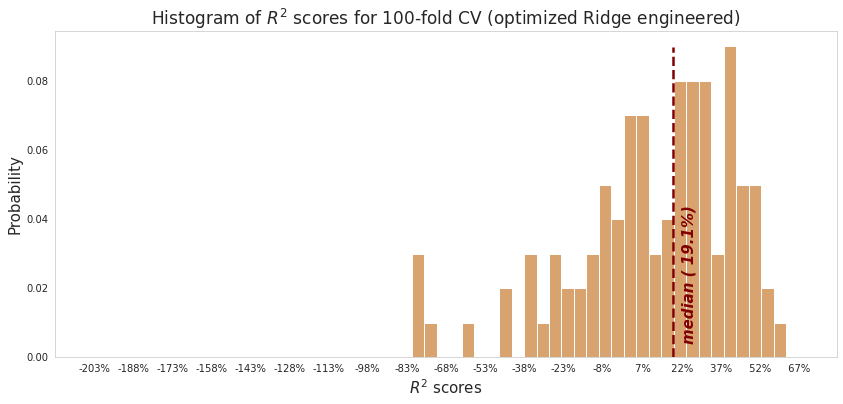

In [580]:
r2 = np.array(r2_fin[best_idx])
first = r2.min() if r2.min()<first_bound else first_bound
second = r2.max() if r2.max()>second_bound else second_bound

x_t = np.arange(first, second, 0.15)

fig, ax = plt.subplots(1, 1, figsize=(14, 6))
sns.histplot(r2, stat='probability', bins=30, color='peru')

ax.set_title(f'Histogram of $R^2$ scores for {spl}-fold CV (optimized Ridge engineered)', fontsize=17)

ax.set_xticks(x_t)
ax.set_xticklabels([f"{x: .0%}" if x not in [x_t[0], x_t[-1]] else "" for x in x_t])
ax.set_xlabel(r'$R^2$ scores', fontsize=15)
ax.set_ylabel(r'Probability', fontsize=15)

ax.grid(False)

plt.axvline(tot_r2[best_idx][1], 0, 0.95, color='maroon', linewidth=2.5, linestyle='--')
plt.text(median_r2+0.035, 0.05*ax.get_ylim()[1], f'median ({tot_r2[best_idx][1]: .1%})', rotation=90, color='maroon', 
         fontstyle='oblique', fontweight='heavy', fontsize=15)

plt.savefig('images/Ridge_engineered.jpg', bbox_inches='tight', dpi=300)
plt.show()


### LassoCV

In [67]:
np.logspace(-5, 1, 150)

array([1.00000000e-05, 1.09715619e-05, 1.20375170e-05, 1.32070362e-05,
       1.44901815e-05, 1.58979923e-05, 1.74425806e-05, 1.91372352e-05,
       2.09965360e-05, 2.30364794e-05, 2.52746159e-05, 2.77302012e-05,
       3.04243618e-05, 3.33802767e-05, 3.66233771e-05, 4.01815648e-05,
       4.40854524e-05, 4.83686269e-05, 5.30679382e-05, 5.82238167e-05,
       6.38806207e-05, 7.00870182e-05, 7.68964057e-05, 8.43673672e-05,
       9.25641789e-05, 1.01557362e-04, 1.11424288e-04, 1.22249846e-04,
       1.34127175e-04, 1.47158460e-04, 1.61455815e-04, 1.77142246e-04,
       1.94352711e-04, 2.13235280e-04, 2.33952406e-04, 2.56682330e-04,
       2.81620607e-04, 3.08981791e-04, 3.39001283e-04, 3.71937355e-04,
       4.08073370e-04, 4.47720223e-04, 4.91219013e-04, 5.38943979e-04,
       5.91305720e-04, 6.48754729e-04, 7.11785265e-04, 7.80939607e-04,
       8.56812721e-04, 9.40057378e-04, 1.03138977e-03, 1.13159567e-03,
       1.24153719e-03, 1.36216020e-03, 1.49450249e-03, 1.63970266e-03,
      

In [71]:
# Lasso regression with auto-optimization of penalization parameter over a Grid

spl = 100

alpha_grid = np.logspace(-4, 1, 100)  # 100 observations from 1e-4 until 10

mod = LassoCV(alphas=alpha_grid, fit_intercept=True, max_iter=int(1e4), cv=spl, tol=1e-5, selection='cyclic')  
mod.fit(X, Y.ravel())
chosen = mod.alpha_

print(f"\n \t CHOICE OF L1 parameter (across {spl} splits) \n")
print(f"Chosen alpha parameter: \t \t {chosen}")

idx = mod.alphas_.tolist().index(chosen)
score = np.sqrt(mod.mse_path_[idx, :]).mean()
print(f"Avg. RMSE score on training data: {score}\n")

                


 	 CHOICE OF L1 parameter (across 100 splits) 

Chosen alpha parameter: 	 	 0.0001
Avg. RMSE score on training data: 0.015240766500495379



In [72]:
# 100-fold Cross-validation, fixing value of optimized alpha

spl = 100
kf = KFold(n_splits=spl, shuffle=True)
#kf = LeaveOneOut()

r2, rmse = [], []
tot_interc, tot_slopes = [], []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    mod = Lasso(alpha=chosen, fit_intercept=True, tol=1e-5, max_iter=int(1e4), selection='cyclic').fit(X_train, Y_train)
    preds = mod.predict(X_test)
    
    r2.append(r2_score(Y_test, preds))
    rmse.append(np.sqrt(mean_squared_error(Y_test, preds)))
    
    tot_slopes.append(mod.coef_)
    tot_interc.append(mod.intercept_)
    
avg_interc = np.array(tot_interc).mean()

tot_slopes = np.reshape(tot_slopes, (spl, X_train.shape[1]))
avg_slopes = tot_slopes.mean(axis=0)

# averaged score
avg_r2 = np.array(r2).mean()
median_r2 = np.median(r2)

avg_rmse = np.array(rmse).mean()
median_rmse = np.median(rmse)

print(f"\t \t AVG. ACROSS {spl} SPLITS\n")
print(f"Estimated intercept: {avg_interc}")
print(f"Estimated slopes: {avg_slopes}", "\n")

print(f"Average R2 score on holdout sample: {avg_r2: .5%}")
print(f"Median R2 score on holdout sample: {median_r2: .5%}\n")
print(f"Std. deviation of R2 scores on holdout sample: {np.std(np.array(r2))}\n")

print(f"Average RMSE on holdout sample: {avg_rmse}")
print(f"Median RMSE on holdout sample: {median_rmse}")


	 	 AVG. ACROSS 100 SPLITS

Estimated intercept: 0.7302292640893471
Estimated slopes: [0.02833845 0.02743403 0.02872684 0.04038629 0.01286023] 

Average R2 score on holdout sample:  2.51162%
Median R2 score on holdout sample:  6.30123%

Std. deviation of R2 scores on holdout sample: 0.2332902139677891

Average RMSE on holdout sample: 0.015209113780341383
Median RMSE on holdout sample: 0.014866733082550432


In [73]:
pen = chosen*(np.abs(avg_slopes).sum())
print(f"The amount of L1 penalization is: {pen}")

The amount of L1 penalization is: 1.3774584498648008e-05


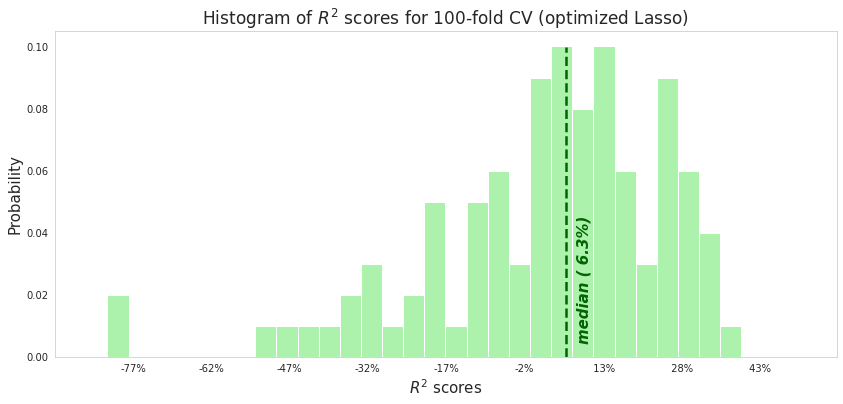

In [84]:
r2_first = np.array(r2)
first_bound = r2_first.min()-0.1
second_bound = r2_first.max()+0.2
x_t_first = np.arange(first_bound, second_bound, 0.15)

fig, ax = plt.subplots(1, 1, figsize=(14, 6))
sns.histplot(r2, stat='probability', bins=30, color='lightgreen')
ax.set_title(f'Histogram of $R^2$ scores for {spl}-fold CV (optimized Lasso)', fontsize=17)

ax.set_xticks(x_t_first)
ax.set_xticklabels([f"{x: .0%}" if x not in [x_t_first[0], x_t_first[-1]] else "" for x in x_t_first])
ax.set_xlabel(r'$R^2$ scores', fontsize=15)
ax.set_ylabel(r'Probability', fontsize=15)

ax.grid(False)

plt.axvline(median_r2, 0, 0.95, color='darkgreen', linewidth=2.5, linestyle='--')
plt.text(median_r2+0.02, 0.05*ax.get_ylim()[1], f'median ({median_r2: .1%})', rotation=90, color='darkgreen', 
         fontstyle='oblique', fontweight='heavy', fontsize=15)

plt.savefig('images/Lasso_CV.jpg', bbox_inches='tight', dpi=300)

plt.show()


In [90]:
# Lasso regression - 100-fold Cross-validation WITH BOOTSTRAP (after auto-tuning)
# find with CV validation the optimized parameter, then average across different bootstrapped samples

spl = 100
kf = KFold(n_splits=spl, shuffle=True)
n_boots = 500

r2, rmse = [], []
tot_interc, tot_slopes = [], []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    X_train = pd.DataFrame(data=X_train, columns=['X' + str(i+1) for i in range(J)])
    Y_train = pd.DataFrame(data=Y_train, columns=['Y'])
    data = pd.concat([X_train, Y_train], axis=1)
    
    boot_interc, boot_slopes = [], []
    
    for _ in range(n_boots):  
        # sample the rows, same size, with replacement out of the training data (1000 times)
        sample_data = data.sample(frac=1, replace=True)
        # fit a linear regression
        Y_tr_boot = sample_data.loc[:, 'Y']
        X_tr_boot = sample_data.loc[:, [p for p in data.columns if p != 'Y']]
        
         # not anymore CV, using previously found alpha
        mod = Lasso(alpha=chosen, fit_intercept=True, tol=1e-5, max_iter=int(1e4), selection='cyclic')
        mod.fit(X_tr_boot, Y_tr_boot)

        boot_interc.append(mod.intercept_)
        boot_slopes.append(mod.coef_)
    
    avg_interc = np.array(boot_interc).mean()
    tot_interc.append(avg_interc)
    
    boot_slopes = np.reshape(boot_slopes, (n_boots, X_tr_boot.shape[1]))
    avg_slopes = boot_slopes.mean(axis=0)
    tot_slopes.append(avg_slopes)
    
    preds = avg_interc + np.matmul(X_test, avg_slopes)
    r2.append(r2_score(Y_test, preds))
    rmse.append(np.sqrt(mean_squared_error(Y_test, preds)))
    
final_interc = np.array(tot_interc).mean()

tot_slopes = np.reshape(tot_slopes, (spl, X_train.shape[1]))
final_slopes = tot_slopes.mean(axis=0)

# averaged score
avg_r2 = np.array(r2).mean()
median_r2 = np.median(r2)

avg_rmse = np.array(rmse).mean()
median_rmse = np.median(rmse)

print(f"\t AVG. ACROSS {spl} SPLITS (WITH {n_boots} BOOT SAMPLES FOR EACH)\n")
print(f"Estimated intercept: {final_interc}")
print(f"Estimated slopes: {final_slopes}", "\n")

print(f"Average R2 score on holdout sample: {avg_r2: .5%}")
print(f"Median R2 score on holdout sample: {median_r2: .5%}\n")
print(f"Std. deviation of R2 scores on holdout sample: {np.std(np.array(r2))}\n")

print(f"Average RMSE on holdout sample: {avg_rmse}")
print(f"Median RMSE on holdout sample: {median_rmse}")



	 AVG. ACROSS 100 SPLITS (WITH 500 BOOT SAMPLES FOR EACH)

Estimated intercept: 0.7303377299952797
Estimated slopes: [0.02822532 0.02720971 0.02836232 0.04026878 0.01393831] 

Average R2 score on holdout sample:  0.33746%
Median R2 score on holdout sample:  4.62678%

Std. deviation of R2 scores on holdout sample: 0.2389598126867618

Average RMSE on holdout sample: 0.015310617728769906
Median RMSE on holdout sample: 0.015402421769566872


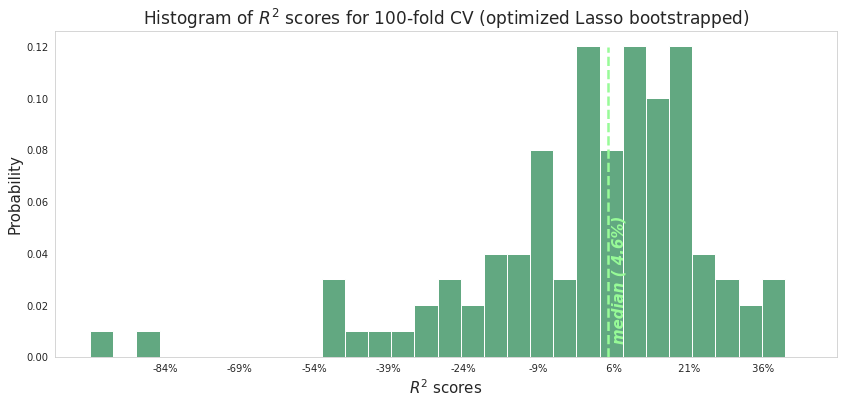

In [96]:
r2 = np.array(r2)

first = r2.min() if r2.min()<first_bound else first_bound
second = r2.max() if r2.max()>second_bound else second_bound

x_t = np.arange(first, second, 0.15)

fig, ax = plt.subplots(1, 1, figsize=(14, 6))
sns.histplot(r2, stat='probability', bins=30, color='seagreen')
ax.set_title(f'Histogram of $R^2$ scores for {spl}-fold CV (optimized Lasso bootstrapped)', fontsize=17)

ax.set_xticks(x_t)
ax.set_xticklabels([f"{x: .0%}" if x not in [x_t[0], x_t[-1]] else "" for x in x_t])
ax.set_xlabel(r'$R^2$ scores', fontsize=15)
ax.set_ylabel(r'Probability', fontsize=15)

ax.grid(False)

plt.axvline(median_r2, 0, 0.95, color='palegreen', linewidth=2.5, linestyle='--')
plt.text(median_r2+0.0065, 0.05*ax.get_ylim()[1], f'median ({median_r2: .1%})', rotation=90, color='palegreen', 
         fontstyle='oblique', fontweight='heavy', fontsize=15)

plt.savefig('images/Lasso_bootstrap.jpg', bbox_inches='tight', dpi=300)
plt.show()


In [543]:
# Lasso with Feature Engineering + PCA
# choice of parameter

spl = 100

alpha_grid = np.logspace(-4, 1, 150)  # 100 observations from 1e-4 until 10

steps=[('Poly', PolynomialFeatures(degree=3, include_bias=False)), ('Scaler', StandardScaler()), 
           ('PCA', PCA(n_components=spec_variance)), ('Lasso', LassoCV(alphas=alpha_grid, fit_intercept=True, max_iter=int(1e4), cv=spl, tol=1e-5, selection='cyclic'))]
    # from 5 to 56 features, then X is standardized, then PCA and components are selected such that they explain >0.85 of variance
    
pipeline=Pipeline(steps)

trained = pipeline.fit(X, Y.ravel())
chosen = trained.named_steps['Lasso'].alpha_

print(f"\n \t CHOICE OF L1 parameter (across {spl} splits) \n")
print(f"Chosen alpha parameter: \t \t {chosen}")

idx = trained.named_steps['Lasso'].alphas_.tolist().index(chosen)
score = np.sqrt(trained.named_steps['Lasso'].mse_path_[idx, :]).mean()
print(f"Avg. RMSE score on training data: {score}\n")


 	 CHOICE OF L1 parameter (across 100 splits) 

Chosen alpha parameter: 	 	 0.0001
Avg. RMSE score on training data: 0.012241186045877902



In [592]:
# 100-fold Cross-validation, PCA + FEATURE ENGINEERING (POLYNOMIAL FEATURES)

spl = 100
kf = KFold(n_splits=spl, shuffle=True)

perc_variance_explained = np.arange(0.4, 1, step=0.1)

tot_avg_components = []
tot_avg_intercept = []
tot_avg_slopes = []
tot_r2 = []
tot_rmse = []
to_plot = []

for i, spec_variance in enumerate(perc_variance_explained.tolist()):
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)
    
    r2, rmse = [], []
    tot_interc, tot_slopes = [], []
    n_components = []

    steps=[('Poly', PolynomialFeatures(degree=3, include_bias=False)), ('Scaler', StandardScaler()), 
           ('PCA', PCA(n_components=spec_variance)), ('Lasso', Lasso(alpha=chosen, fit_intercept=True, tol=1e-5, max_iter=int(1e4), selection='cyclic'))]
    # from 5 to 56 features, then X is standardized, then PCA and components are selected such that they explain >0.85 of variance
    
    pipeline=Pipeline(steps)
    
    for train_index, test_index in kf.split(X):            

        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        lr = pipeline.fit(X_train, Y_train)
        preds = lr.predict(X_test)

        n_components.append(lr.named_steps['PCA'].n_components_)

        r2.append(r2_score(Y_test, preds))
        rmse.append(np.sqrt(mean_squared_error(Y_test, preds)))
        
        tot_slopes.append(lr.named_steps['Lasso'].coef_)
        tot_interc.append(lr.named_steps['Lasso'].coef_)
        
    to_plot.append(r2)

    n_components = np.array(n_components)
    avg_components = int(n_components.mean())
    tot_avg_components.append(avg_components)

    avg_interc=np.array(tot_interc).mean()
    tot_avg_intercept.append(avg_interc)

    tot_slopes = np.reshape(tot_slopes, (spl, n_components[-1]))
    avg_slopes = tot_slopes.mean(axis=0)
    tot_avg_slopes.append(avg_slopes)

    # averaged score
    avg_r2 = np.array(r2).mean()
    median_r2 = np.median(r2)
    tot_r2.append([avg_r2, median_r2])

    avg_rmse = np.array(rmse).mean()
    median_rmse = np.median(rmse)
    tot_rmse.append([avg_rmse, median_rmse])
    
    if i==0:
        best_r2 = avg_r2
        best_idx = 0
    if avg_r2>best_r2:
        best_r2 = avg_r2
        best_idx = i

print(f"\t \t AVG. ACROSS {spl} SPLITS (with Polynomial Features and PCA)\n")
print(f"Best choice for the n. of components: those that explain more than{perc_variance_explained[best_idx]: .2%} of variance, on average {tot_avg_components[best_idx]}\n")
print(f"Estimated intercept: {tot_avg_intercept[best_idx]}")
print(f"Estimated slopes: {tot_avg_slopes[best_idx]}", "\n")

print(f"Average R2 score on holdout sample: {tot_r2[best_idx][0]: .5%}")
print(f"Median R2 score on holdout sample: {tot_r2[best_idx][1]: .5%}\n")
print(f"Std. deviation of R2 scores on holdout sample: {np.std(to_plot[best_idx])}\n")

print(f"Average RMSE on holdout sample: {tot_rmse[best_idx][0]}")
print(f"Median RMSE on holdout sample: {tot_rmse[best_idx][1]}\n")



	 	 AVG. ACROSS 100 SPLITS (with Polynomial Features and PCA)

Best choice for the n. of components: those that explain more than 90.00% of variance, on average 4

Estimated intercept: -0.0003823164885414453
Estimated slopes: [ 0.00049218 -0.00080315 -0.0016743   0.000456  ] 

Average R2 score on holdout sample:  10.23418%
Median R2 score on holdout sample:  12.81647%

Std. deviation of R2 scores on holdout sample: 0.2782174057580342

Average RMSE on holdout sample: 0.012137854984810216
Median RMSE on holdout sample: 0.012167065845318457



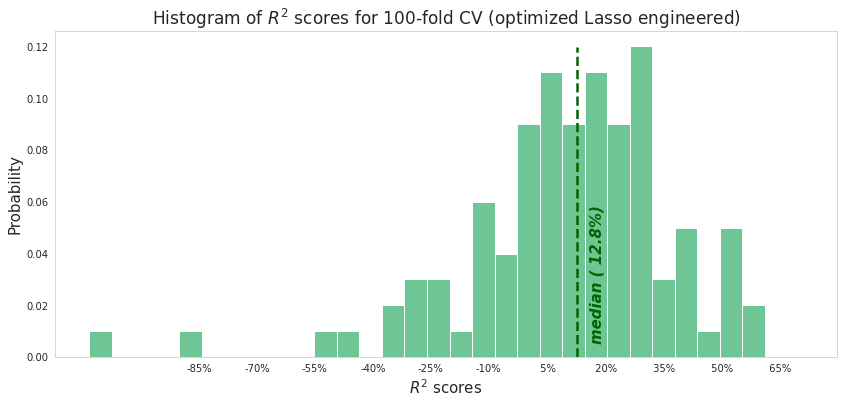

In [596]:
r2 = np.array(to_plot[best_idx])

first = -1.0#r2.min() if r2.min()<first_bound else first_bound
second = r2.max() if r2.max()>second_bound else second_bound

x_t = np.arange(first, second, 0.15)

fig, ax = plt.subplots(1, 1, figsize=(14, 6))
sns.histplot(r2, stat='probability', bins=30, color='mediumseagreen')
ax.set_title(f'Histogram of $R^2$ scores for {spl}-fold CV (optimized Lasso engineered)', fontsize=17)

ax.set_xticks(x_t)
ax.set_xticklabels([f"{x: .0%}" if x not in [x_t[0], x_t[-1]] else "" for x in x_t])
ax.set_xlabel(r'$R^2$ scores', fontsize=15)
ax.set_ylabel(r'Probability', fontsize=15)

ax.grid(False)

plt.axvline(tot_r2[best_idx][1], 0, 0.95, color='darkgreen', linewidth=2.5, linestyle='--')
plt.text(tot_r2[best_idx][1]+0.033, 0.05*ax.get_ylim()[1], f'median ({tot_r2[best_idx][1]: .1%})', rotation=90, color='darkgreen', 
         fontstyle='oblique', fontweight='heavy', fontsize=15)

plt.savefig('images/Lasso_engineered.jpg', bbox_inches='tight', dpi=300)
plt.show()


In [544]:
pen = chosen*(np.abs(tot_avg_slopes[best_idx]).sum())
print(f"The amount of L1 penalization is: {pen}")

The amount of L1 penalization is: 3.4302102973052164e-07


### Elastic Net

In [548]:
alpha_grid = np.logspace(-4, 1, 100)    # weight of penalization (both)
l_grid = np.linspace(0.05, 1, 200).tolist()  # trade-off L1-L2

In [549]:
# ElasticNet with auto-parameter tuning, to understand trade-off Lasso-Ridge

split = 100

mod = ElasticNetCV(l1_ratio=l_grid, alphas=alpha_grid, cv=split, selection='cyclic', tol=1e-5, max_iter=int(1e4))
mod.fit(X, Y.ravel())

chosen_alpha = mod.alpha_
chosen_lratio = mod.l1_ratio_

print(f"\n \t CHOICE OF alpha and L1-L2 trade-off (across {spl} splits) \n")
print(f"Alpha estimated for the best model: {chosen_alpha}")
print(f"Chosen l-ratio parameter: {chosen_lratio}\n")  # closer to L2 penalization

idx_alpha = alpha_grid.tolist().index(chosen_alpha)
idx_l_ratio = l_grid.index(chosen_lratio)
score = np.sqrt(mod.mse_path_[idx_l_ratio, idx_alpha, :]).mean()
print(f"Avg. RMSE score on training data: {score}\n")
                


 	 CHOICE OF alpha and L1-L2 trade-off (across 100 splits) 

Alpha estimated for the best model: 0.0001
Chosen l-ratio parameter: 0.05

Avg. RMSE score on training data: 0.0138190199992488



In [106]:
# 100-fold Cross-validation, fixing value of optimized alpha

spl = 100
kf = KFold(n_splits=spl, shuffle=True)
#kf = LeaveOneOut()

r2, rmse = [], []
tot_interc, tot_slopes = [], []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    mod = ElasticNet(alpha=chosen_alpha, l1_ratio=chosen_lratio, tol=1e-5, max_iter=int(1e4), selection='cyclic') # selection='random'
    mod.fit(X_train, Y_train)
    preds = mod.predict(X_test)
    
    r2.append(r2_score(Y_test, preds))
    rmse.append(np.sqrt(mean_squared_error(Y_test, preds)))
    
    tot_slopes.append(mod.coef_)
    tot_interc.append(mod.intercept_)
    
avg_interc = np.array(tot_interc).mean()

tot_slopes = np.reshape(tot_slopes, (spl, X_train.shape[1]))
avg_slopes = tot_slopes.mean(axis=0)

# averaged score
avg_r2 = np.array(r2).mean()
median_r2 = np.median(r2)

avg_rmse = np.array(rmse).mean()
median_rmse = np.median(rmse)

print(f"\t \t AVG. ACROSS {spl} SPLITS\n")
print(f"Estimated intercept: {avg_interc}")
print(f"Estimated slopes: {avg_slopes}", "\n")

print(f"Average R2 score on holdout sample: {avg_r2: .5%}")
print(f"Median R2 score on holdout sample: {median_r2: .5%}\n")
print(f"Std. deviation of R2 scores on holdout sample: {np.std(np.array(r2))}\n")

print(f"Average RMSE on holdout sample: {avg_rmse}")
print(f"Median RMSE on holdout sample: {median_rmse}")


	 	 AVG. ACROSS 100 SPLITS

Estimated intercept: 0.617539364314107
Estimated slopes: [0.0327364  0.08064149 0.10561013 0.06781087 0.09114745] 

Average R2 score on holdout sample:  12.69578%
Median R2 score on holdout sample:  17.83166%

Std. deviation of R2 scores on holdout sample: 0.28882082041681906

Average RMSE on holdout sample: 0.014331000978410622
Median RMSE on holdout sample: 0.014237990743226358


In [107]:
pen_l1 = chosen_alpha*chosen_lratio*(np.abs(avg_slopes).sum())
pen_l2 = 0.5*chosen_alpha*(1-chosen_lratio)*(np.square(avg_slopes).sum())

print(f"The amount of L1 penalization is: {pen_l1}")
print(f"The amount of L2 penalization is: {pen_l2}")

The amount of L1 penalization is: 1.8897317543274783e-06
The amount of L2 penalization is: 1.5026337426114428e-06


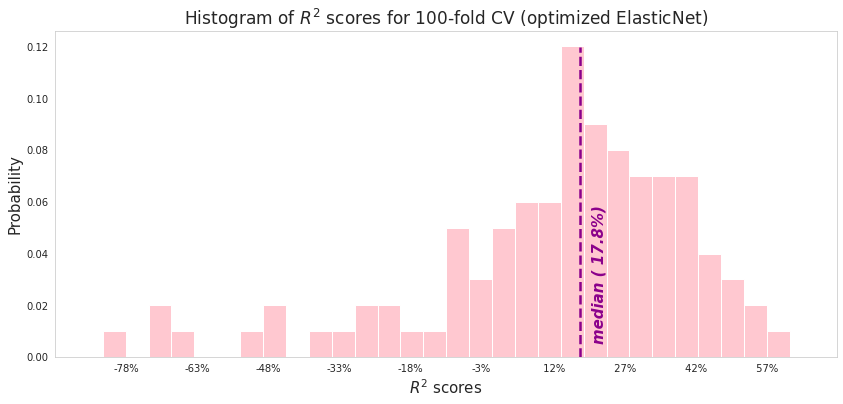

In [109]:
r2_first = np.array(r2)
first_bound = r2_first.min()-0.1
second_bound = r2_first.max()+0.2
x_t_first = np.arange(first_bound, second_bound, 0.15)

fig, ax = plt.subplots(1, 1, figsize=(14, 6))
sns.histplot(r2, stat='probability', bins=30, color='lightpink')
ax.set_title(f'Histogram of $R^2$ scores for {spl}-fold CV (optimized ElasticNet)', fontsize=17)

ax.set_xticks(x_t_first)
ax.set_xticklabels([f"{x: .0%}" if x not in [x_t_first[0], x_t_first[-1]] else "" for x in x_t_first])
ax.set_xlabel(r'$R^2$ scores', fontsize=15)
ax.set_ylabel(r'Probability', fontsize=15)

ax.grid(False)

plt.axvline(median_r2, 0, 0.95, color='darkmagenta', linewidth=2.5, linestyle='--')
plt.text(median_r2+0.023, 0.05*ax.get_ylim()[1], f'median ({median_r2: .1%})', rotation=90, color='darkmagenta', 
         fontstyle='oblique', fontweight='heavy', fontsize=15)

plt.savefig('images/ElasticNet_CV.jpg', bbox_inches='tight', dpi=300)
plt.show()


In [110]:
# ElasticNet regression- 100-fold Cross-validation WITH BOOTSTRAP (after auto-tuning)

spl = 100
kf = KFold(n_splits=spl, shuffle=True)
n_boots = 500

r2, rmse = [], []
tot_interc, tot_slopes = [], []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    X_train = pd.DataFrame(data=X_train, columns=['X' + str(i+1) for i in range(J)])
    Y_train = pd.DataFrame(data=Y_train, columns=['Y'])
    data = pd.concat([X_train, Y_train], axis=1)
    
    boot_interc, boot_slopes = [], []
    
    for _ in range(n_boots):  
        # sample the rows, same size, with replacement out of the training data (1000 times)
        sample_data = data.sample(frac=1, replace=True)
        # fit a linear regression
        Y_tr_boot = sample_data.loc[:, 'Y']
        X_tr_boot = sample_data.loc[:, [p for p in data.columns if p != 'Y']]
        
         # not anymore CV, using previously found alpha
        mod = ElasticNet(alpha=chosen_alpha, l1_ratio=chosen_lratio, tol=1e-5, max_iter=int(1e4), selection='cyclic')
        mod.fit(X_tr_boot, Y_tr_boot)

        boot_interc.append(mod.intercept_)
        boot_slopes.append(mod.coef_)
    
    avg_interc = np.array(boot_interc).mean()
    tot_interc.append(avg_interc)
    
    boot_slopes = np.reshape(boot_slopes, (n_boots, X_tr_boot.shape[1]))
    avg_slopes = boot_slopes.mean(axis=0)
    tot_slopes.append(avg_slopes)
    
    preds = avg_interc + np.matmul(X_test, avg_slopes)
    r2.append(r2_score(Y_test, preds))
    rmse.append(np.sqrt(mean_squared_error(Y_test, preds)))
    
final_interc = np.array(tot_interc).mean()

tot_slopes = np.reshape(tot_slopes, (spl, X_train.shape[1]))
final_slopes = tot_slopes.mean(axis=0)

# averaged score
avg_r2 = np.array(r2).mean()
median_r2 = np.median(r2)

avg_rmse = np.array(rmse).mean()
median_rmse = np.median(rmse)

print(f"\t AVG. ACROSS {spl} SPLITS (WITH {n_boots} BOOT SAMPLES FOR EACH)\n")
print(f"Estimated intercept: {final_interc}")
print(f"Estimated slopes: {final_slopes}", "\n")

print(f"Average R2 score on holdout sample: {avg_r2: .5%}")
print(f"Median R2 score on holdout sample: {median_r2: .5%}\n")
print(f"Std. deviation of R2 scores on holdout sample: {np.std(np.array(r2))}\n")

print(f"Average RMSE on holdout sample: {avg_rmse}")
print(f"Median RMSE on holdout sample: {median_rmse}")


	 AVG. ACROSS 100 SPLITS (WITH 500 BOOT SAMPLES FOR EACH)

Estimated intercept: 0.6177248279464022
Estimated slopes: [0.03270685 0.08047706 0.1055343  0.06780171 0.09105174] 

Average R2 score on holdout sample:  10.17614%
Median R2 score on holdout sample:  15.44921%

Std. deviation of R2 scores on holdout sample: 0.33636790185318133

Average RMSE on holdout sample: 0.014388203044960295
Median RMSE on holdout sample: 0.014769414913947409


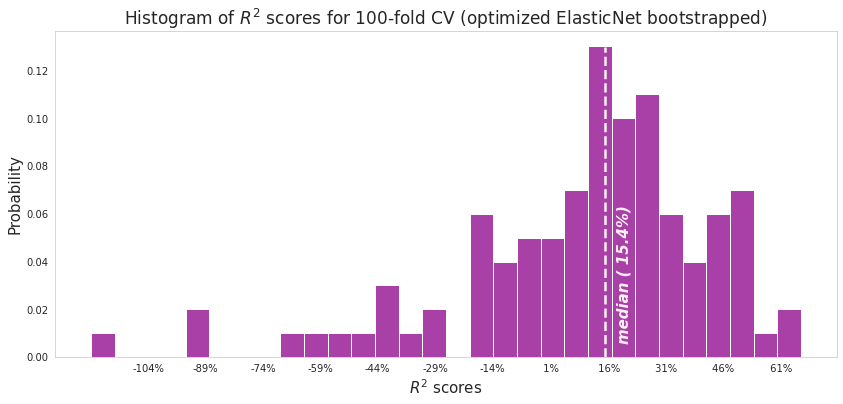

In [114]:
r2 = np.array(r2)

first = r2.min() if r2.min()<first_bound else first_bound
second = r2.max() if r2.max()>second_bound else second_bound

x_t = np.arange(first, second, 0.15)

fig, ax = plt.subplots(1, 1, figsize=(14, 6))
sns.histplot(r2, stat='probability', bins=30, color='darkmagenta')
ax.set_title(f'Histogram of $R^2$ scores for {spl}-fold CV (optimized ElasticNet bootstrapped)', fontsize=17)

ax.set_xticks(x_t)
ax.set_xticklabels([f"{x: .0%}" if x not in [x_t[0], x_t[-1]] else "" for x in x_t])
ax.set_xlabel(r'$R^2$ scores', fontsize=15)
ax.set_ylabel(r'Probability', fontsize=15)

ax.grid(False)

plt.axvline(median_r2, 0, 0.95, color='lavenderblush', linewidth=2.5, linestyle='--')
plt.text(median_r2+0.03, 0.05*ax.get_ylim()[1], f'median ({median_r2: .1%})', rotation=90, color='lavenderblush', 
         fontstyle='oblique', fontweight='heavy', fontsize=15)

plt.savefig('images/ElasticNet_bootstrap.jpg', bbox_inches='tight', dpi=300)

plt.show()


In [602]:
# 100-fold Cross-validation, PCA + FEATURE ENGINEERING (POLYNOMIAL FEATURES)

spl = 100
kf = KFold(n_splits=spl, shuffle=True)

#kf = LeaveOneOut()

perc_variance_explained = np.arange(0.1, 1, step=0.05)

tot_avg_components = []
tot_avg_intercept = []
tot_avg_slopes = []
tot_r2 = []
tot_rmse = []
to_plot = []

for i, spec_variance in enumerate(perc_variance_explained.tolist()):
    
    r2, rmse = [], []
    tot_interc, tot_slopes = [], []
    n_components = []

    steps=[('Poly', PolynomialFeatures(degree=3, include_bias=False)), ('Scaler', StandardScaler()), 
           ('PCA', PCA(n_components=spec_variance)), ('Elastic', ElasticNet(alpha=chosen_alpha, l1_ratio=chosen_lratio, tol=1e-5, max_iter=int(1e4), selection='cyclic'))]
    # from 5 to 56 features, then X is standardized, then PCA and components are selected such that they explain >0.85 of variance
    
    pipeline=Pipeline(steps)

    for train_index, test_index in kf.split(X):            

        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        lr = pipeline.fit(X_train, Y_train)
        preds = lr.predict(X_test)

        n_components.append(lr.named_steps['PCA'].n_components_)

        r2.append(r2_score(Y_test, preds))
        rmse.append(np.sqrt(mean_squared_error(Y_test, preds)))

        tot_slopes.append(lr.named_steps['Elastic'].coef_)
        tot_interc.append(lr.named_steps['Elastic'].coef_)
        
    to_plot.append(r2)

    n_components = np.array(n_components)
    avg_components = int(n_components.mean())
    tot_avg_components.append(avg_components)

    avg_interc=np.array(tot_interc).mean()
    tot_avg_intercept.append(avg_interc)

    tot_slopes = np.reshape(tot_slopes, (spl, n_components[-1]))
    avg_slopes = tot_slopes.mean(axis=0)
    tot_avg_slopes.append(avg_slopes)

    # averaged score
    avg_r2 = np.array(r2).mean()
    median_r2 = np.median(r2)
    tot_r2.append([avg_r2, median_r2])

    avg_rmse = np.array(rmse).mean()
    median_rmse = np.median(rmse)
    tot_rmse.append([avg_rmse, median_rmse])
    
    if i==0:
        best_r2 = avg_r2
        best_idx = 0
    if avg_r2>best_r2:
        best_r2 = avg_r2
        best_idx = i

print(f"\t \t AVG. ACROSS {spl} SPLITS (with Polynomial Features and PCA)\n")
print(f"Best choice for the n. of components: those that explain more than{perc_variance_explained[best_idx]: .2%} of variance, on average {tot_avg_components[best_idx]}\n")
print(f"Estimated intercept: {tot_avg_intercept[best_idx]}")
print(f"Estimated slopes: {tot_avg_slopes[best_idx]}", "\n")

print(f"Average R2 score on holdout sample: {tot_r2[best_idx][0]: .5%}")
print(f"Median R2 score on holdout sample: {tot_r2[best_idx][1]: .5%}\n")
print(f"Std. deviation of R2 scores on holdout sample: {np.std(np.array(to_plot[best_idx])): .5f}\n")

print(f"Average RMSE on holdout sample: {tot_rmse[best_idx][0]: .5f}")
print(f"Median RMSE on holdout sample: {tot_rmse[best_idx][1]: 5f}\n")



	 	 AVG. ACROSS 100 SPLITS (with Polynomial Features and PCA)

Best choice for the n. of components: those that explain more than 95.00% of variance, on average 5

Estimated intercept: -0.0006229971345945999
Estimated slopes: [ 0.00049682 -0.00080981 -0.00168606  0.00047144 -0.00158736] 

Average R2 score on holdout sample:  13.95708%
Median R2 score on holdout sample:  21.07253%

Std. deviation of R2 scores on holdout sample:  0.31507

Average RMSE on holdout sample:  0.01173
Median RMSE on holdout sample:  0.012068



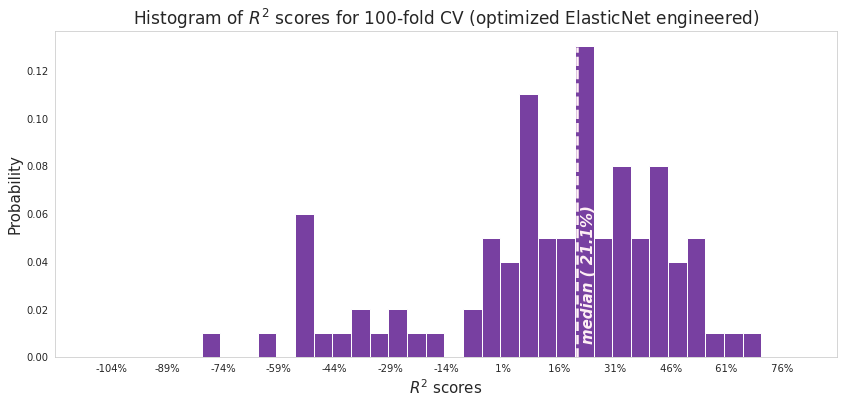

In [614]:
r2 = np.array(to_plot[best_idx])

first = r2.min() if r2.min()<first_bound else first_bound 
second = r2.max() if r2.max()>second_bound else second_bound

x_t = np.arange(first, second, 0.15)

fig, ax = plt.subplots(1, 1, figsize=(14, 6))
sns.histplot(r2, stat='probability', bins=30, color='indigo')
ax.set_title(f'Histogram of $R^2$ scores for {spl}-fold CV (optimized ElasticNet engineered)', fontsize=17)

ax.set_xticks(x_t)
ax.set_xticklabels([f"{x: .0%}" if x not in [x_t[0], x_t[-1]] else "" for x in x_t])
ax.set_xlabel(r'$R^2$ scores', fontsize=15)
ax.set_ylabel(r'Probability', fontsize=15)

ax.grid(False)

plt.axvline(tot_r2[best_idx][1], 0, 0.95, color='lavenderblush', linewidth=2.5, linestyle='--')
plt.text(tot_r2[best_idx][1]+0.012, 0.05*ax.get_ylim()[1], f'median ({tot_r2[best_idx][1]: .1%})', rotation=90, color='lavenderblush', 
         fontstyle='oblique', fontweight='heavy', fontsize=15)

plt.savefig('images/ElasticNet_engineered.jpg', bbox_inches='tight', dpi=300)

plt.show()


### Decision Trees

In [121]:
# Alone

mod = DecisionTreeRegressor()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

trained = mod.fit(X_train, Y_train)
preds = trained.predict(X_test)

print(f"N. of leaves of fitted (optimized) tree: {trained.get_n_leaves()}")
print(f"Depth of fitted (optimized) tree: {trained.get_depth()}\n")

print(f"R2 score on holdout sample: {r2_score(Y_test, preds): .5%}")
print(f"RMSE score on holdout sample: {np.sqrt(mean_squared_error(Y_test, preds))}")


N. of leaves of fitted (optimized) tree: 719
Depth of fitted (optimized) tree: 20

R2 score on holdout sample: -62.11833%
RMSE score on holdout sample: 0.02225308967312182


In [126]:
# 100-fold Cross-validation

spl = 100
kf = KFold(n_splits=spl, shuffle=True)

r2, rmse = [], []
tot_leaves, tot_depth = [], []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    mod = DecisionTreeRegressor()
    trained = mod.fit(X_train, Y_train)
    preds = trained.predict(X_test)
    
    r2.append(r2_score(Y_test, preds))
    rmse.append(np.sqrt(mean_squared_error(Y_test, preds)))
    
    tot_leaves.append(trained.get_n_leaves())
    tot_depth.append(trained.get_depth())
    
avg_leaves = np.round(np.array(tot_leaves).mean(), 0)
avg_depth = np.round(np.array(tot_depth).mean(), 0)

# averaged score
avg_r2 = np.array(r2).mean()
median_r2 = np.median(r2)

avg_rmse = np.array(rmse).mean()
median_rmse = np.median(rmse)

print(f"\t \t AVG. ACROSS {spl} SPLITS\n")
print(f"Avg. number of leaves of fitted trees: {int(avg_leaves)}")
print(f"Avg. depth of fitted trees: {int(avg_depth)}", "\n")

print(f"Average R2 score on holdout sample: {avg_r2: .5%}")
print(f"Median R2 score on holdout sample: {median_r2: .5%}\n")
print(f"Std. deviation of R2 scores on holdout sample: {np.std(np.array(r2))}\n")

print(f"Average RMSE on holdout sample: {avg_rmse}")
print(f"Median RMSE on holdout sample: {median_rmse}")


	 	 AVG. ACROSS 100 SPLITS

Avg. number of leaves of fitted trees: 876
Avg. depth of fitted trees: 22 

Average R2 score on holdout sample: -94.35234%
Median R2 score on holdout sample: -57.22509%

Std. deviation of R2 scores on holdout sample: 1.2295732294455428

Average RMSE on holdout sample: 0.020139082887169115
Median RMSE on holdout sample: 0.019974757875273037


In [128]:
# WITH GRID

dtree = DecisionTreeRegressor()

parameters={"splitter":["best","random"],
            "max_depth" : [1,3,5,9,12,None],
           "min_samples_leaf":[1,2,4,7,10],
           "max_features":[None,"sqrt","log2"],
           "max_leaf_nodes":[None,2,5,7,10,30,50,90] }

split = 100
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

grid = GridSearchCV(estimator=dtree, cv=split, param_grid=parameters, scoring='r2', n_jobs=-1, verbose=0)     
trained = grid.fit(X_train, Y_train)

cv_scores = [trained.cv_results_['split' + str(x) + '_test_score'][trained.best_index_] for x in range(split)]
best_score_grid = trained.best_score_
median_r2 = np.median(cv_scores)
assert np.isclose(np.array(cv_scores).mean(), best_score_grid), 'better see'

best_mod = trained.best_estimator_
best_params = trained.best_params_
depth = best_mod.get_depth()
leaves = best_mod.get_n_leaves()

# holdout
preds =  best_mod.predict(X_test)
r2 = r2_score(Y_test, preds)
rmse = np.sqrt(mean_squared_error(Y_test, preds))

print(f"\n\tAVG. ACROSS {spl} SPLITS (with GridSearch) \n")

print(f"\nParameters chosen for the optimized model: \n {best_params}\n")
print(f"N. of leaves of fitted tree: {leaves}")
print(f"Depth of fitted tree: {depth}\n")

print(f"Feature importances: \n {best_mod.feature_importances_}\n")
print(f"Avg. R2 score of optimized model: {best_score_grid: .5%}")
print(f"Median R2 score of optimized model: {median_r2: .5%}")
print(f"Std. deviation of R2 scores of optimized model: {np.std(cv_scores)}\n")

print(f"\n \t \t HOLDOUT SAMPLE\n")
print(f"R2 score on holdout sample: {r2: .5%}")
print(f"RMSE on holdout sample: {rmse}\n \n")

# tends to create a very large number or leaves, need to properly control


	AVG. ACROSS 100 SPLITS (with GridSearch) 


Parameters chosen for the optimized model: 
 {'max_depth': 9, 'max_features': None, 'max_leaf_nodes': 10, 'min_samples_leaf': 10, 'splitter': 'best'}

N. of leaves of fitted tree: 10
Depth of fitted tree: 4

Feature importances: 
 [0.07708954 0.24580726 0.20663912 0.32884543 0.14161865]

Avg. R2 score of optimized model: -7.51591%
Median R2 score of optimized model:  9.63108%
Std. deviation of R2 scores of optimized model: 0.6538037149730112


 	 	 HOLDOUT SAMPLE

R2 score on holdout sample:  14.86275%
RMSE on holdout sample: 0.015866111078849002
 



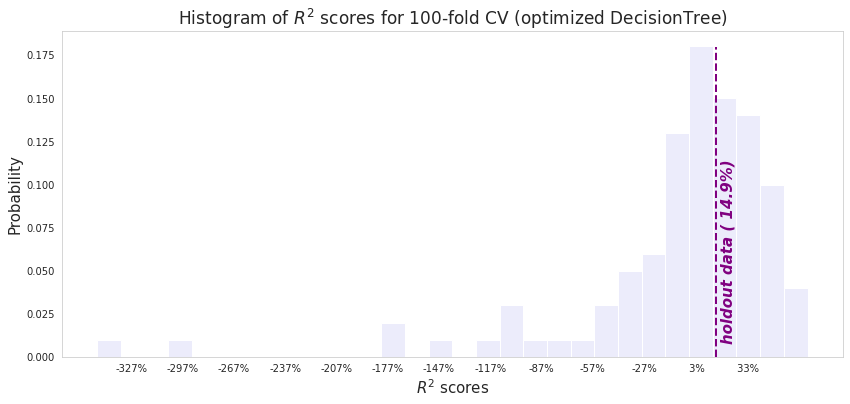

In [132]:
r2_cv = np.array(cv_scores)
x_t = np.arange(r2_cv.min()-0.1, r2_cv.max()+0.2, 0.3)

fig, ax = plt.subplots(1, 1, figsize=(14, 6))
sns.histplot(r2_cv, stat='probability', bins=30, color='lavender')
ax.set_title(f'Histogram of $R^2$ scores for {split}-fold CV (optimized DecisionTree)', fontsize=17)

ax.set_xticks(x_t)
ax.set_xticklabels([f"{x: .0%}" if x not in [x_t[0], x_t[-1]] else "" for x in x_t])
ax.set_xlabel(r'$R^2$ scores', fontsize=15)
ax.set_ylabel(r'Probability', fontsize=15)

ax.grid(False)

plt.axvline(r2, 0, 0.95, color='purple', linewidth=2, linestyle='--')
plt.text(r2+0.025, 0.05*ax.get_ylim()[1], f'holdout data ({r2: .1%})', rotation=90, color='purple', 
         fontstyle='oblique', fontweight='heavy', fontsize=15)

plt.savefig('images/DecisionTree_Grid.jpg', bbox_inches='tight', dpi=300)
plt.show()


## Ensemble learning

#### RandomForest Regressor

In [133]:
# Alone (with bootstrap)

dtree2 = RandomForestRegressor(bootstrap=True, verbose=0, max_samples=0.8)  # max_samples for bootstrap

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

trained = dtree2.fit(X_train, Y_train.ravel())
preds = trained.predict(X_test)

n_sub = len(trained.estimators_)  # 100 is default
leav_sub = np.round(np.array([x.get_n_leaves() for x in trained.estimators_]).mean(), 0)
dep_sub = np.round(np.array([x.get_depth() for x in trained.estimators_]).mean(), 0)  # None is Default

print(f"\nN. of sub-estimators: {n_sub}")
print(f"Avg. number of leaves of sub-estimators: {int(leav_sub)}")
print(f"Avg. depth of sub-estimators: {int(dep_sub)}\n")

print(f"R2 score on holdout sample: {r2_score(Y_test, preds): .5%}")
print(f"RMSE score on holdout sample: {np.sqrt(mean_squared_error(Y_test, preds))}")



N. of sub-estimators: 100
Avg. number of leaves of sub-estimators: 392
Avg. depth of sub-estimators: 20

R2 score on holdout sample:  18.59617%
RMSE score on holdout sample: 0.015408527833638138


In [135]:
# 100-fold Cross-validation

spl = 100
kf = KFold(n_splits=spl, shuffle=True)

r2, rmse = [], []
tot_n_sub, tot_leaf_sub, tot_dep_sub = [], [], []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    mod = RandomForestRegressor(bootstrap=True, verbose=0, max_samples=0.8)
    trained = mod.fit(X_train, Y_train.ravel())
    preds = trained.predict(X_test)
    
    r2.append(r2_score(Y_test, preds))
    rmse.append(np.sqrt(mean_squared_error(Y_test, preds)))
    
    tot_n_sub.append(len(trained.estimators_))
    tot_leaf_sub.append(np.array([x.get_n_leaves() for x in trained.estimators_]).mean())
    tot_dep_sub.append(np.array([x.get_depth() for x in trained.estimators_]).mean())

avg_n_sub = np.round(np.array(tot_n_sub).mean(), 0)
avg_leaf_sub = np.round(np.array(tot_leaf_sub).mean(), 0)
avg_dep_sub = np.round(np.array(tot_dep_sub).mean(), 0)

# averaged score
avg_r2 = np.array(r2).mean()
median_r2 = np.median(r2)

avg_rmse = np.array(rmse).mean()
median_rmse = np.median(rmse)

print(f"\n\t AVG. ACROSS {spl} SPLITS\n")

print(f"Avg. number of sub-estimators: {int(avg_n_sub)}")
print(f"Avg. number of leaves of sub-estimators: {int(avg_leaf_sub)}")
print(f"Avg. depth of sub-estimators: {int(avg_dep_sub)}\n")

print(f"Average R2 score on holdout sample: {avg_r2: .5%}")
print(f"Median R2 score on holdout sample: {median_r2: .5%}\n")
print(f"Std. deviation of R2 scores on holdout sample: {np.std(np.array(r2))}\n")

print(f"Average RMSE on holdout sample: {avg_rmse}")
print(f"Median RMSE on holdout sample: {median_rmse}")



	 AVG. ACROSS 100 SPLITS

Avg. number of sub-estimators: 100
Avg. number of leaves of sub-estimators: 485
Avg. depth of sub-estimators: 21

Average R2 score on holdout sample:  7.96208%
Median R2 score on holdout sample:  16.40640%

Std. deviation of R2 scores on holdout sample: 0.3728072269596813

Average RMSE on holdout sample: 0.014464673682739144
Median RMSE on holdout sample: 0.014358431244830612


In [136]:
# WITH GRID

dtree2 = RandomForestRegressor(bootstrap=True, verbose=0, max_samples=0.8)

parameters={"n_estimators":[20, 50, 100, 150],
            "max_depth" : [1,3,5,7,11,15],
            "min_samples_leaf":[1,2,4,8,10],
           "max_features":[1.0,"sqrt"],
           "max_leaf_nodes": [None,2,5,10,30,50,90] }

split = 100
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

grid = GridSearchCV(estimator=dtree2, cv=split, param_grid=parameters, scoring='r2', n_jobs=-1, verbose=1)  
trained = grid.fit(X_train, Y_train.ravel())  

cv_scores = [trained.cv_results_['split' + str(x) + '_test_score'][trained.best_index_] for x in range(split)]
best_score_grid = trained.best_score_
median_r2 = np.median(cv_scores)
assert np.isclose(np.array(cv_scores).mean(), best_score_grid), 'better see'

best_mod = trained.best_estimator_
best_params = trained.best_params_

n_sub = len(best_mod.estimators_)  # 100 is default
leav_sub = np.round(np.array([x.get_n_leaves() for x in best_mod.estimators_]).mean(), 0)
dep_sub = np.round(np.array([x.get_depth() for x in best_mod.estimators_]).mean(), 0)  # None is Default

# holdout
preds =  best_mod.predict(X_test)
r2 = r2_score(Y_test, preds)
rmse = np.sqrt(mean_squared_error(Y_test, preds))

print(f"\n\t AVG. ACROSS {spl} SPLITS (with GridSearch) \n")

print(f"\nParameters chosen for the optimized model: \n {best_params}\n")

print(f"N. of fitted model's sub-estimators: {n_sub}")
print(f"Avg. number of leaves of fitted model's sub-estimators : {leav_sub}")
print(f"Avg. depth of fitted model's sub-estimators: {dep_sub}\n")

print(f"Feature importances: \n {best_mod.feature_importances_}\n")
print(f"Avg. R2 score of optimized model: {best_score_grid: .5%}")
print(f"Median R2 score of optimized model: {median_r2: .5%}")
print(f"Std. deviation of R2 scores of optimized model: {np.std(cv_scores)}\n")

print(f"\n \t \t HOLDOUT SAMPLE\n")
print(f"R2 score on holdout sample: {r2: .5%}")
print(f"RMSE on holdout sample: {rmse}")

# tends to create a very large number or leaves, need to properly control

Fitting 100 folds for each of 1680 candidates, totalling 168000 fits

	 AVG. ACROSS 100 SPLITS (with GridSearch) 


Parameters chosen for the optimized model: 
 {'max_depth': 11, 'max_features': 'sqrt', 'max_leaf_nodes': 50, 'min_samples_leaf': 10, 'n_estimators': 150}

N. of fitted model's sub-estimators: 150
Avg. number of leaves of fitted model's sub-estimators : 34.0
Avg. depth of fitted model's sub-estimators: 9.0

Feature importances: 
 [0.18596609 0.16114421 0.20801357 0.26795841 0.17691773]

Avg. R2 score of optimized model: -0.43328%
Median R2 score of optimized model:  10.21340%
Std. deviation of R2 scores of optimized model: 0.44866267434321083


 	 	 HOLDOUT SAMPLE

R2 score on holdout sample:  17.85010%
RMSE on holdout sample: 0.014231268314069869


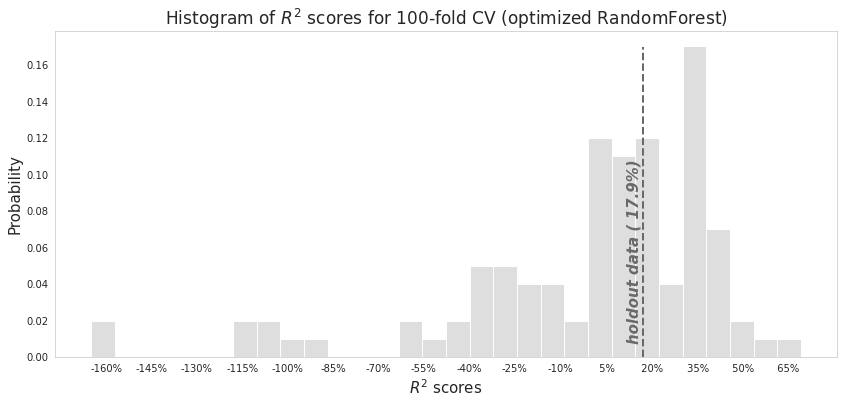

In [143]:
r2_first = np.array(cv_scores)
first_bound = r2_first.min()-0.1
second_bound = r2_first.max()+0.2
x_t_first = np.arange(first_bound, second_bound, 0.15)

fig, ax = plt.subplots(1, 1, figsize=(14, 6))
sns.histplot(r2_first, stat='probability', bins=30, color='lightgray')
ax.set_title(f'Histogram of $R^2$ scores for {split}-fold CV (optimized RandomForest)', fontsize=17)

ax.set_xticks(x_t_first)
ax.set_xticklabels([f"{x: .0%}" if x not in [x_t_first[0], x_t_first[-1]] else "" for x in x_t_first])
ax.set_xlabel(r'$R^2$ scores', fontsize=15)
ax.set_ylabel(r'Probability', fontsize=15)

ax.grid(False)

plt.axvline(r2, 0, 0.95, color='dimgray', linewidth=2, linestyle='--')
plt.text(r2-0.055, 0.05*ax.get_ylim()[1], f'holdout data ({r2: .1%})', rotation=90, color='dimgray', 
         fontstyle='oblique', fontweight='heavy', fontsize=15)

plt.savefig('images/RandomForest_Grid.jpg', bbox_inches='tight', dpi=300)
plt.show()


In [172]:
# GRID SEARCH WITH FEATURE ENGINEERING

split = 100

parameters={"Forest__n_estimators":[20, 50, 100, 150],
            "Forest__max_depth" : [1,3,5,7,11,15],
            "Forest__min_samples_leaf":[1,2,4,8,10],
           "Forest__max_features":[1.0,"sqrt"],
           "Forest__max_leaf_nodes": [None,2,5,10,30,50,90] }

steps=[('Poly', PolynomialFeatures(degree=4, include_bias=False)), ('Scaler', StandardScaler()),
       ('Forest', RandomForestRegressor(bootstrap=True, verbose=0, max_samples=0.8))]
# from 5 to 125 features, then X is standardized, then PCA and components are selected such that they explain >0.85 of variance

grid = GridSearchCV(Pipeline(steps), cv=split, param_grid=parameters, scoring='r2', n_jobs=-1, verbose=1)  
trained = grid.fit(X_train, Y_train.ravel())  

cv_scores = [trained.cv_results_['split' + str(x) + '_test_score'][trained.best_index_] for x in range(split)]
best_score_grid = trained.best_score_
median_r2 = np.median(cv_scores)
assert np.isclose(np.array(cv_scores).mean(), best_score_grid), 'better see'

best_mod = trained.best_estimator_
best_params = trained.best_params_

n_sub = len(best_mod['Forest'].estimators_)  # 100 is default
leav_sub = np.round(np.array([x.get_n_leaves() for x in best_mod['Forest'].estimators_]).mean(), 0)
dep_sub = np.round(np.array([x.get_depth() for x in best_mod['Forest'].estimators_]).mean(), 0)  # None is Default

# holdout
preds =  best_mod.predict(X_test)
r2 = r2_score(Y_test, preds)
rmse = np.sqrt(mean_squared_error(Y_test, preds))

print(f"\n\t AVG. ACROSS {spl} SPLITS (with GridSearch) \n")
print(f"\nParameters chosen for the optimized model: \n {best_params}\n")

print(f"N. of fitted model's sub-estimators: {n_sub}")
print(f"Avg. number of leaves of fitted model's sub-estimators : {leav_sub}")
print(f"Avg. depth of fitted model's sub-estimators: {dep_sub}\n")

#print(f"Feature importances: \n {best_mod['Forest'].feature_importances_}\n")
print(f"Avg. R2 score of optimized model: {best_score_grid: .5%}")
print(f"Median R2 score of optimized model: {median_r2: .5%}")
print(f"Std. deviation of R2 scores of optimized model: {np.std(cv_scores)}\n")

print(f"\n \t \t HOLDOUT SAMPLE\n")
print(f"R2 score on holdout sample: {r2: .5%}")
print(f"RMSE on holdout sample: {rmse}")


Fitting 100 folds for each of 1680 candidates, totalling 168000 fits

	 AVG. ACROSS 100 SPLITS (with GridSearch) 


Parameters chosen for the optimized model: 
 {'Forest__max_depth': 5, 'Forest__max_features': 'sqrt', 'Forest__max_leaf_nodes': 5, 'Forest__min_samples_leaf': 2, 'Forest__n_estimators': 50}

N. of fitted model's sub-estimators: 50
Avg. number of leaves of fitted model's sub-estimators : 5.0
Avg. depth of fitted model's sub-estimators: 3.0

Avg. R2 score of optimized model:  1.06357%
Median R2 score of optimized model:  11.85973%
Std. deviation of R2 scores of optimized model: 0.4355143980181587


 	 	 HOLDOUT SAMPLE

R2 score on holdout sample:  22.61977%
RMSE on holdout sample: 0.01381195339661123


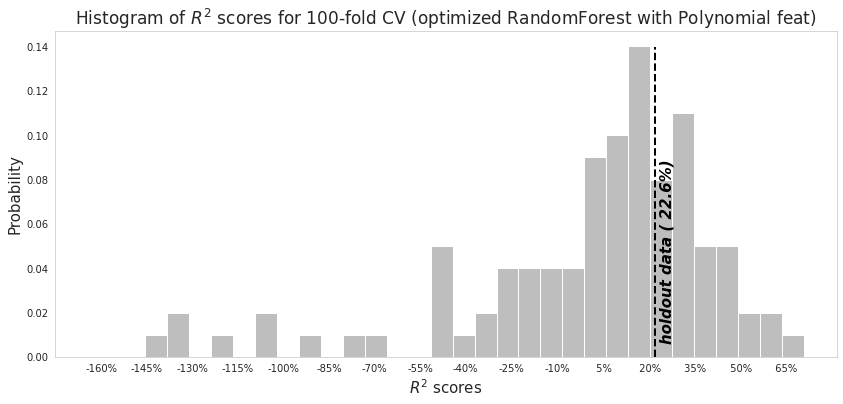

In [180]:
r2_eng = np.array(cv_scores)

first = r2_eng.min() if r2_eng.min()<first_bound else first_bound
second = r2_eng.max() if r2_eng.max()>second_bound else second_bound

x_t = np.arange(first, second, 0.15)

fig, ax = plt.subplots(1, 1, figsize=(14, 6))
sns.histplot(r2_eng, stat='probability', bins=30, color='darkgrey')
ax.set_title(f'Histogram of $R^2$ scores for {split}-fold CV (optimized RandomForest with Polynomial feat)', fontsize=17)

ax.set_xticks(x_t)
ax.set_xticklabels([f"{x: .0%}" if x not in [x_t[0], x_t[-1]] else "" for x in x_t])
ax.set_xlabel(r'$R^2$ scores', fontsize=15)
ax.set_ylabel(r'Probability', fontsize=15)

ax.grid(False)

plt.axvline(r2, 0, 0.95, color='black', linewidth=2, linestyle='--')
plt.text(r2+0.015, 0.05*ax.get_ylim()[1], f'holdout data ({r2: .1%})', rotation=90, color='black', 
         fontstyle='oblique', fontweight='heavy', fontsize=15)

plt.savefig('images/RandomForest_Polynomial.jpg', bbox_inches='tight', dpi=300)
plt.show()


In [182]:
# GRID SEARCH WITH FEATURE ENGINEERING FROM NEURAL NETWORKS

dtree_net = RandomForestRegressor(bootstrap=True, verbose=0, max_samples=0.8)

parameters={"n_estimators":[20, 50, 100, 150],
            "max_depth" : [1,3,5,7,11,15],
            "min_samples_leaf":[1,2,4,8,10],
           "max_features":[1.0,"sqrt"],
           "max_leaf_nodes": [None,2,5,10,30,50,90] }

split = 100

X_train_eng, X_test_eng = create_features(X_train, X_test, Y_train, Y_test)

grid = GridSearchCV(estimator=dtree_net, cv=split, param_grid=parameters, scoring='r2', n_jobs=-1, verbose=0)  
trained = grid.fit(X_train_eng, Y_train.ravel())  

cv_scores_eng = [trained.cv_results_['split' + str(x) + '_test_score'][trained.best_index_] for x in range(split)]
best_score_grid_eng = trained.best_score_
median_r2_eng = np.median(cv_scores)
assert np.isclose(np.array(cv_scores_eng).mean(), best_score_grid_eng), 'better see'

best_mod_eng = trained.best_estimator_
best_params_eng = trained.best_params_

n_sub = len(best_mod_eng.estimators_)  # 100 is default
leav_sub = np.round(np.array([x.get_n_leaves() for x in best_mod_eng.estimators_]).mean(), 0)
dep_sub = np.round(np.array([x.get_depth() for x in best_mod_eng.estimators_]).mean(), 0)  # None is Default

# holdout
preds =  best_mod_eng.predict(X_test_eng)
r2_eng = r2_score(Y_test, preds)
rmse_eng = np.sqrt(mean_squared_error(Y_test, preds))

print(f"\n\t AVG. ACROSS {spl} SPLITS (with GridSearch) \n")

print(f"\nParameters chosen for the optimized model: \n {best_params_eng}\n")

print(f"N. of fitted model's sub-estimators: {n_sub}")
print(f"Avg. number of leaves of fitted model's sub-estimators : {leav_sub}")
print(f"Avg. depth of fitted model's sub-estimators: {dep_sub}\n")

#print(f"Feature importances: \n {best_mod.feature_importances_}\n")
print(f"Avg. R2 score of optimized model: {best_score_grid_eng: .5%}")
print(f"Median R2 score of optimized model: {median_r2_eng: .5%}")
print(f"Std. deviation of R2 scores of optimized model: {np.std(cv_scores_eng)}\n")

print(f"\n \t \t HOLDOUT SAMPLE\n")
print(f"R2 score on holdout sample: {r2_eng: .5%}")
print(f"RMSE on holdout sample: {rmse_eng}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 5)                20        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 first_hidden (Dense)        (None, 30)                180       
                                                                 
 batch_normalization_1 (Batc  (None, 30)               120       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 second_hidden (Dense)       (None, 100)               3

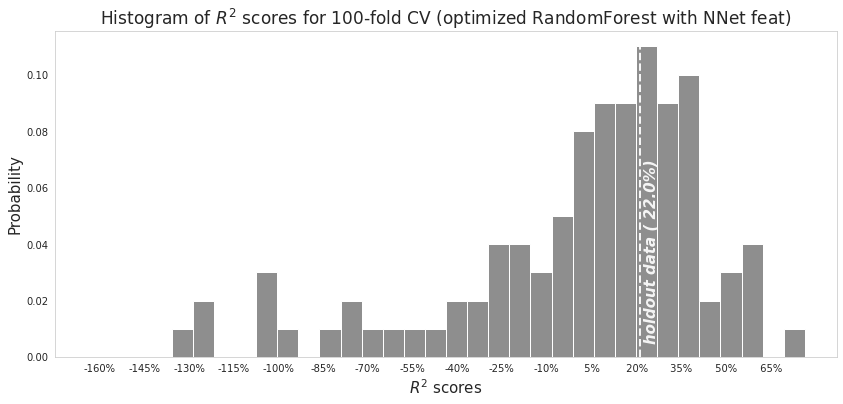

In [196]:
r2_net = np.array(cv_scores_eng)

first = r2_net.min() if r2_net.min()<first_bound else first_bound
second = r2_net.max() if r2_net.max()>second_bound else second_bound

x_t = np.arange(first, second, 0.15)

fig, ax = plt.subplots(1, 1, figsize=(14, 6))
sns.histplot(r2_net, stat='probability', bins=30, color='dimgray')
ax.set_title(f'Histogram of $R^2$ scores for {split}-fold CV (optimized RandomForest with NNet feat)', fontsize=17)

ax.set_xticks(x_t)
ax.set_xticklabels([f"{x: .0%}" if x not in [x_t[0], x_t[-1]] else "" for x in x_t])
ax.set_xlabel(r'$R^2$ scores', fontsize=15)
ax.set_ylabel(r'Probability', fontsize=15)

ax.grid(False)

plt.axvline(r2_eng, 0, 0.95, color='whitesmoke', linewidth=2, linestyle='--')
plt.text(r2_eng+0.012, 0.05*ax.get_ylim()[1], f'holdout data ({r2_eng: .1%})', rotation=90, color='whitesmoke', 
         fontstyle='oblique', fontweight='heavy', fontsize=15)

plt.savefig('images/RandomForest_NNet.jpg', bbox_inches='tight', dpi=300)
plt.show()


#### ExtraTrees Regressor

In [220]:
# Alone (with bootstrap)

extratree = ExtraTreesRegressor(bootstrap=True)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

trained = extratree.fit(X_train, Y_train.ravel())
preds = trained.predict(X_test)

n_sub = len(trained.estimators_)  # 100 is default
leav_sub = np.round(np.array([x.get_n_leaves() for x in trained.estimators_]).mean(), 0)
dep_sub = np.round(np.array([x.get_depth() for x in trained.estimators_]).mean(), 0)  # None is Default

print(f"N. of sub-estimators: {n_sub}")
print(f"Avg. number of leaves of sub-estimators: {int(leav_sub)}")
print(f"Avg. depth of sub-estimators: {int(dep_sub)}\n")

print(f"R2 score on holdout sample: {r2_score(Y_test, preds): .5%}")
print(f"RMSE score on holdout sample: {np.sqrt(mean_squared_error(Y_test, preds))}")


N. of sub-estimators: 100
Avg. number of leaves of sub-estimators: 483
Avg. depth of sub-estimators: 21

R2 score on holdout sample:  19.86402%
RMSE score on holdout sample: 0.015062557950096016


In [222]:
# 100-fold Cross-validation

spl = 100
kf = KFold(n_splits=spl, shuffle=True)

r2, rmse = [], []
tot_n_sub, tot_leaf_sub, tot_dep_sub = [], [], []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    mod = ExtraTreesRegressor(bootstrap=True)
    trained = mod.fit(X_train, Y_train.ravel())
    preds = trained.predict(X_test)
    
    r2.append(r2_score(Y_test, preds))
    rmse.append(np.sqrt(mean_squared_error(Y_test, preds)))
    
    tot_n_sub.append(len(trained.estimators_))
    tot_leaf_sub.append(np.array([x.get_n_leaves() for x in trained.estimators_]).mean())
    tot_dep_sub.append(np.array([x.get_depth() for x in trained.estimators_]).mean())

avg_n_sub = np.round(np.array(tot_n_sub).mean(), 0)
avg_leaf_sub = np.round(np.array(tot_leaf_sub).mean(), 0)
avg_dep_sub = np.round(np.array(tot_dep_sub).mean(), 0)

# averaged score
avg_r2 = np.array(r2).mean()
median_r2 = np.median(r2)

avg_rmse = np.array(rmse).mean()
median_rmse = np.median(rmse)

print(f"\t AVG. ACROSS {spl} SPLITS\n")

print(f"Avg. number of sub-estimators: {int(avg_n_sub)}")
print(f"Avg. number of leaves of sub-estimators: {int(avg_leaf_sub)}")
print(f"Avg. depth of sub-estimators: {int(avg_dep_sub)}\n")

print(f"Average R2 score on holdout sample: {avg_r2: .5%}")
print(f"Median R2 score on holdout sample: {median_r2: .5%}\n")
print(f"Std. deviation of R2 scores on holdout sample: {np.std(np.array(r2))}\n")

print(f"Average RMSE on holdout sample: {avg_rmse}")
print(f"Median RMSE on holdout sample: {median_rmse}")


	 AVG. ACROSS 100 SPLITS

Avg. number of sub-estimators: 100
Avg. number of leaves of sub-estimators: 599
Avg. depth of sub-estimators: 22

Average R2 score on holdout sample:  8.77861%
Median R2 score on holdout sample:  16.26046%

Std. deviation of R2 scores on holdout sample: 0.39297349873531595

Average RMSE on holdout sample: 0.01444772233081852
Median RMSE on holdout sample: 0.014323949901841132


In [232]:
# WITH GRID

extratree = ExtraTreesRegressor(bootstrap=True)  # max_samples=1 with bootstrap (default)

parameters={"n_estimators":[20, 50, 100, 150],
            "max_depth" : [1,3,5, 11, 30, None],  # leave sample leaves to default since was performing better
           "max_features":[1.0,"sqrt"],
           "max_leaf_nodes": [None,5,10,30,50,100] }

split = 100
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

grid = GridSearchCV(estimator=extratree, cv=split, param_grid=parameters, scoring='r2', n_jobs=-1, verbose=1)
trained = grid.fit(X_train, Y_train.ravel())                                  

cv_scores = [trained.cv_results_['split' + str(x) + '_test_score'][trained.best_index_] for x in range(split)]
best_score_grid = trained.best_score_
median_r2 = np.median(cv_scores)
assert np.isclose(np.array(cv_scores).mean(), best_score_grid), 'better see'

best_mod = trained.best_estimator_
best_params = trained.best_params_

n_sub = len(best_mod.estimators_)  # 100 is default
leav_sub = np.round(np.array([x.get_n_leaves() for x in best_mod.estimators_]).mean(), 0)
dep_sub = np.round(np.array([x.get_depth() for x in best_mod.estimators_]).mean(), 0)  # None is Default

# holdout
preds =  best_mod.predict(X_test)
r2 = r2_score(Y_test, preds)
rmse = np.sqrt(mean_squared_error(Y_test, preds))

print(f"\t AVG. ACROSS {spl} SPLITS (with GridSearch) \n")

print(f"\nParameters chosen for the optimized model: \n {best_params}\n")

print(f"N. of fitted model's sub-estimators: {n_sub}")
print(f"Avg. number of leaves of fitted model's sub-estimators : {leav_sub}")
print(f"Avg. depth of fitted model's sub-estimators: {dep_sub}\n")

print(f"Feature importances: \n {best_mod.feature_importances_}\n")
print(f"Avg. R2 score of optimized model: {best_score_grid: .5%}")
print(f"Median R2 score of optimized model: {median_r2: .5%}")
print(f"Std. deviation of R2 scores of optimized model: {np.std(cv_scores)}\n")

print(f"\n \t \t HOLDOUT SAMPLE\n")
print(f"R2 score on holdout sample: {r2: .5%}")
print(f"RMSE on holdout sample: {rmse}")


Fitting 100 folds for each of 288 candidates, totalling 28800 fits
	 AVG. ACROSS 100 SPLITS (with GridSearch) 


Parameters chosen for the optimized model: 
 {'max_depth': 11, 'max_features': 'sqrt', 'max_leaf_nodes': 100, 'n_estimators': 100}

N. of fitted model's sub-estimators: 100
Avg. number of leaves of fitted model's sub-estimators : 100.0
Avg. depth of fitted model's sub-estimators: 11.0

Feature importances: 
 [0.20735382 0.19568603 0.18034788 0.24210602 0.17450626]

Avg. R2 score of optimized model:  3.29793%
Median R2 score of optimized model:  12.66613%
Std. deviation of R2 scores of optimized model: 0.3731519457177754


 	 	 HOLDOUT SAMPLE

R2 score on holdout sample:  24.94476%
RMSE on holdout sample: 0.0153120043166859


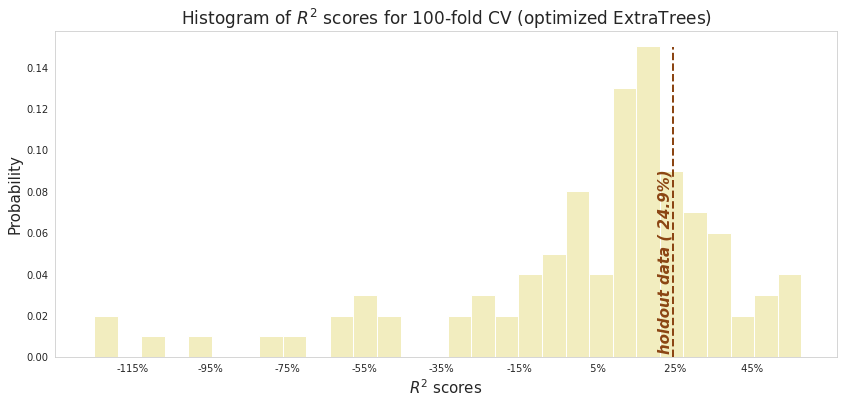

In [238]:
r2_first = np.array(cv_scores)
first_bound = r2_first.min()-0.1
second_bound = r2_first.max()+0.2
x_t_first = np.arange(first_bound, second_bound, 0.2)

fig, ax = plt.subplots(1, 1, figsize=(14, 6))
sns.histplot(r2_first, stat='probability', bins=30, color='palegoldenrod')
ax.set_title(f'Histogram of $R^2$ scores for {split}-fold CV (optimized ExtraTrees)', fontsize=17)

ax.set_xticks(x_t_first)
ax.set_xticklabels([f"{x: .0%}" if x not in [x_t_first[0], x_t_first[-1]] else "" for x in x_t_first])
ax.set_xlabel(r'$R^2$ scores', fontsize=15)
ax.set_ylabel(r'Probability', fontsize=15)

ax.grid(False)

plt.axvline(r2, 0, 0.95, color='saddlebrown', linewidth=2, linestyle='--')
plt.text(r2-0.042, 0.02*ax.get_ylim()[1], f'holdout data ({r2: .1%})', rotation=90, color='saddlebrown', 
         fontstyle='oblique', fontweight='heavy', fontsize=15)

plt.savefig('images/ExtraTrees_Grid.jpg', bbox_inches='tight', dpi=300)
plt.show()


In [245]:
# GRID SEARCH WITH FEATURE ENGINEERING

split = 100

parameters={"Extra__n_estimators":[20, 50, 100, 350, 500],
            "Extra__max_depth" : [1,3,5, 11, 30, None], 
            #"Extra__min_samples_leaf":[0.5, 0.8, 1, 3, 5,10],
           "Extra__max_features":[1.0,"sqrt"],
           "Extra__max_leaf_nodes": [None,2,5,10,30,50,90] }

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

steps=[('Poly', PolynomialFeatures(degree=4, include_bias=False)), ('Scaler', StandardScaler()),
       ('Extra', ExtraTreesRegressor(bootstrap=True))]
# from 5 to 125 features, then X is standardized, then PCA and components are selected such that they explain >0.85 of variance

grid = GridSearchCV(Pipeline(steps), cv=split, param_grid=parameters, scoring='r2', n_jobs=-1, verbose=1)  
trained = grid.fit(X_train, Y_train.ravel())  

cv_scores = [trained.cv_results_['split' + str(x) + '_test_score'][trained.best_index_] for x in range(split)]
best_score_grid = trained.best_score_
median_r2 = np.median(cv_scores)
assert np.isclose(np.array(cv_scores).mean(), best_score_grid), 'better see'

best_mod = trained.best_estimator_
best_params = trained.best_params_

n_sub = len(best_mod['Extra'].estimators_)  # 100 is default
leav_sub = np.round(np.array([x.get_n_leaves() for x in best_mod['Extra'].estimators_]).mean(), 0)
dep_sub = np.round(np.array([x.get_depth() for x in best_mod['Extra'].estimators_]).mean(), 0)  # None is Default                                  

# holdout
preds =  best_mod.predict(X_test)
r2 = r2_score(Y_test, preds)
rmse = np.sqrt(mean_squared_error(Y_test, preds))

print(f"\t AVG. ACROSS {spl} SPLITS (with GridSearch) \n")
print(f"\nParameters chosen for the optimized model: \n {best_params}\n")

print(f"N. of fitted model's sub-estimators: {n_sub}")
print(f"Avg. number of leaves of fitted model's sub-estimators : {leav_sub}")
print(f"Avg. depth of fitted model's sub-estimators: {dep_sub}\n")

#print(f"Feature importances: \n {best_mod.feature_importances_}\n")
print(f"Avg. R2 score of optimized model: {best_score_grid: .5%}")
print(f"Median R2 score of optimized model: {median_r2: .5%}")
print(f"Std. deviation of R2 scores of optimized model: {np.std(cv_scores)}\n")

print(f"\n \t \t HOLDOUT SAMPLE\n")
print(f"R2 score on holdout sample: {r2: .5%}")
print(f"RMSE on holdout sample: {rmse}")

Fitting 100 folds for each of 420 candidates, totalling 42000 fits
	 AVG. ACROSS 100 SPLITS (with GridSearch) 


Parameters chosen for the optimized model: 
 {'Extra__max_depth': None, 'Extra__max_features': 'sqrt', 'Extra__max_leaf_nodes': 30, 'Extra__n_estimators': 500}

N. of fitted model's sub-estimators: 500
Avg. number of leaves of fitted model's sub-estimators : 30.0
Avg. depth of fitted model's sub-estimators: 9.0

Avg. R2 score of optimized model:  8.24401%
Median R2 score of optimized model:  10.38111%
Std. deviation of R2 scores of optimized model: 0.34334379338785304


 	 	 HOLDOUT SAMPLE

R2 score on holdout sample:  21.46396%
RMSE on holdout sample: 0.01564688591423524


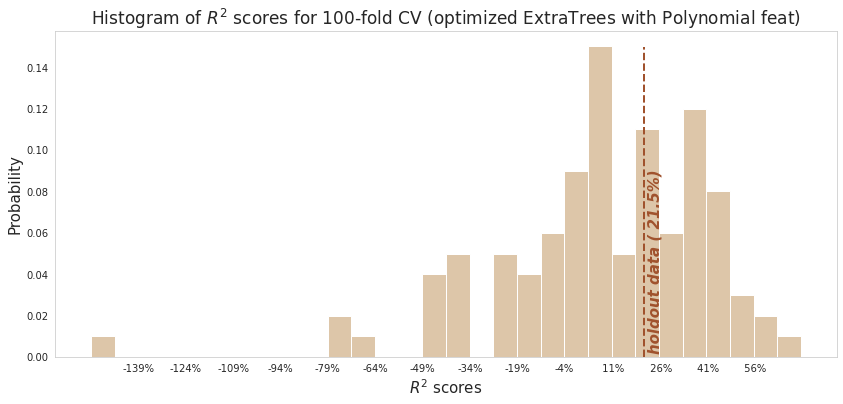

In [250]:
r2_eng = np.array(cv_scores)

first = r2_eng.min() if r2_eng.min()<first_bound else first_bound
second = r2_eng.max() if r2_eng.max()>second_bound else second_bound

x_t = np.arange(first, second, 0.15)

fig, ax = plt.subplots(1, 1, figsize=(14, 6))
sns.histplot(r2_eng, stat='probability', bins=30, color='tan')
ax.set_title(f'Histogram of $R^2$ scores for {split}-fold CV (optimized ExtraTrees with Polynomial feat)', fontsize=17)

ax.set_xticks(x_t)
ax.set_xticklabels([f"{x: .0%}" if x not in [x_t[0], x_t[-1]] else "" for x in x_t])
ax.set_xlabel(r'$R^2$ scores', fontsize=15)
ax.set_ylabel(r'Probability', fontsize=15)

ax.grid(False)

plt.axvline(r2, 0, 0.95, color='sienna', linewidth=2, linestyle='--')
plt.text(r2+0.012, 0.02*ax.get_ylim()[1], f'holdout data ({r2: .1%})', rotation=90, color='sienna', 
         fontstyle='oblique', fontweight='heavy', fontsize=15)

plt.savefig('images/ExtraTrees_Polynomial.jpg', bbox_inches='tight', dpi=300)
plt.show()


In [251]:
# GRID SEARCH WITH FEATURE ENGINEERING FROM NEURAL NETWORKS

extratree_net = ExtraTreesRegressor(bootstrap=True)

parameters={"n_estimators":[20, 50, 100, 350, 500],
            "max_depth" : [1,3,5, 11, 30, None],
            "min_samples_leaf":[1,2,4,8,10],
           "max_features":[1.0,"sqrt"],
           "max_leaf_nodes": [None,2,5,10,30,50,90] }

split = 100

X_train_eng, X_test_eng = create_features(X_train, X_test, Y_train, Y_test)

grid = GridSearchCV(estimator=extratree_net, cv=split, param_grid=parameters, scoring='r2', n_jobs=-1, verbose=1)  
trained = grid.fit(X_train_eng, Y_train.ravel())  

cv_scores = [trained.cv_results_['split' + str(x) + '_test_score'][trained.best_index_] for x in range(split)]
best_score_grid = trained.best_score_
median_r2 = np.median(cv_scores)
assert np.isclose(np.array(cv_scores).mean(), best_score_grid), 'better see'

best_mod = trained.best_estimator_
best_params = trained.best_params_

n_sub = len(best_mod.estimators_)  # 100 is default
leav_sub = np.round(np.array([x.get_n_leaves() for x in best_mod.estimators_]).mean(), 0)
dep_sub = np.round(np.array([x.get_depth() for x in best_mod.estimators_]).mean(), 0)  # None is Default

# holdout
preds =  best_mod.predict(X_test_eng)
r2 = r2_score(Y_test, preds)
rmse = np.sqrt(mean_squared_error(Y_test, preds))

print(f"\n\t AVG. ACROSS {spl} SPLITS (with GridSearch) \n")

print(f"\nParameters chosen for the optimized model: \n {best_params}\n")

print(f"N. of fitted model's sub-estimators: {n_sub}")
print(f"Avg. number of leaves of fitted model's sub-estimators : {leav_sub}")
print(f"Avg. depth of fitted model's sub-estimators: {dep_sub}\n")

print(f"Feature importances: \n {best_mod.feature_importances_}\n")
print(f"Avg. R2 score of optimized model: {best_score_grid: .5%}")
print(f"Median R2 score of optimized model: {median_r2: .5%}")
print(f"Std. deviation of R2 scores of optimized model: {np.std(cv_scores)}\n")

print(f"\n \t \t HOLDOUT SAMPLE\n")
print(f"R2 score on holdout sample: {r2: .5%}")
print(f"RMSE on holdout sample: {rmse}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 5)                20        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 first_hidden (Dense)        (None, 30)                180       
                                                                 
 batch_normalization_1 (Batc  (None, 30)               120       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 second_hidden (Dense)       (None, 100)               3

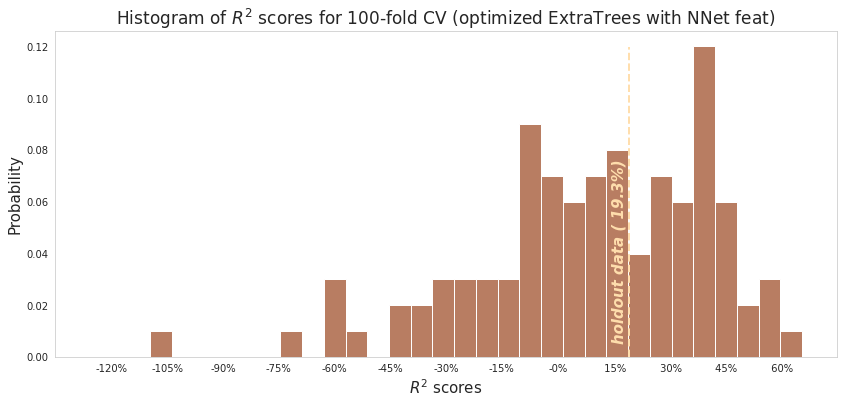

In [258]:
r2_net = np.array(cv_scores)

first = r2_net.min() if r2_net.min()<first_bound else first_bound
second = r2_net.max() if r2_net.max()>second_bound else second_bound

x_t = np.arange(first, second, 0.15)

fig, ax = plt.subplots(1, 1, figsize=(14, 6))
sns.histplot(r2_net, stat='probability', bins=30, color='sienna')
ax.set_title(f'Histogram of $R^2$ scores for {split}-fold CV (optimized ExtraTrees with NNet feat)', fontsize=17)

ax.set_xticks(x_t)
ax.set_xticklabels([f"{x: .0%}" if x not in [x_t[0], x_t[-1]] else "" for x in x_t])
ax.set_xlabel(r'$R^2$ scores', fontsize=15)
ax.set_ylabel(r'Probability', fontsize=15)

ax.grid(False)

plt.axvline(r2, 0, 0.95, color='navajowhite', linewidth=2, linestyle='--')
plt.text(r2-0.048, 0.05*ax.get_ylim()[1], f'holdout data ({r2: .1%})', rotation=90, color='navajowhite', 
         fontstyle='oblique', fontweight='heavy', fontsize=15)

plt.savefig('images/ExtraTrees_NNet.jpg', bbox_inches='tight', dpi=300)
plt.show()


### XGBoost

In [261]:
# Alone (with bootstrap)

xgb_model = xgb.XGBRegressor(n_jobs=-1, objective="reg:squarederror", eval_metric=r2_score)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

trained = xgb_model.fit(X_train, Y_train.ravel())
preds = trained.predict(X_test)

print(f"\nParameters chosen for the fitted model: \n {trained.get_params()}\n")

print(f"R2 score on holdout sample: {r2_score(Y_test, preds): .5%}")
print(f"RMSE score on holdout sample: {np.sqrt(mean_squared_error(Y_test, preds))}")



Parameters chosen for the fitted model: 
 {'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': <function r2_score at 0x7fdf3e51c310>, 'gamma': 0, 'gpu_id': -1, 'grow_policy': 'depthwise', 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_bin': 256, 'max_cat_to_onehot': 4, 'max_delta_step': 0, 'max_depth': 6, 'max_leaves': 0, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': -1, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'sampling_method': 'uniform', 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}

R2 score on holdout sample:  14.59510%
RMSE score on holdout sample: 0.015293209741166791


In [269]:
# WITH GRID

xgb_model = xgb.XGBRegressor(n_jobs=-1, objective="reg:squarederror", eval_metric=r2_score)  #early_stopping_rounds 

params = {
    "colsample_bytree": [0.6, 0.8, 1], # default 1
    "gamma": [0, 0.1, 0.3, 0.5, 1], # default 0, min loss required for partition
    "learning_rate": [0.1, 0.2, 0.3, float(np.round(np.random.uniform(0.4, 1, 1), 1))], # default 0.3
    "max_depth": [1,3,5,7,11, None], # default 3
    "n_estimators": [100, 150, 200, 400], # default 100
    "subsample": [0.5, 0.75, 1]  # default 1
}

split = 100

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

grid = GridSearchCV(estimator=xgb_model, cv=split, param_grid=params, scoring='r2', n_jobs=-1, verbose=1)
trained = grid.fit(X_train, Y_train)                                  
preds = grid.predict(X_test)

cv_scores = [trained.cv_results_['split' + str(x) + '_test_score'][trained.best_index_] for x in range(split)]
best_score_grid = trained.best_score_
median_r2 = np.median(cv_scores)
assert np.isclose(np.array(cv_scores).mean(), best_score_grid), 'better see'

best_mod = trained.best_estimator_
best_params = trained.best_params_

# holdout
preds =  best_mod.predict(X_test)
r2 = r2_score(Y_test, preds)
rmse = np.sqrt(mean_squared_error(Y_test, preds))

print(f"\n\t AVG. ACROSS {spl} SPLITS (with GridSearch) \n")

print(f"\nParameters chosen for the optimized model: {trained.best_params_}\n")
print(f"Feature importances: \n {best_mod.feature_importances_}\n")
print(f"Avg. R2 score of optimized model: {trained.best_score_: .5%}")
print(f"Median R2 score of optimized model: {median_r2: .5%}")
print(f"Std. deviation of R2 scores of optimized model: {np.std(cv_scores)}\n")

print(f"\n \t \t HOLDOUT SAMPLE\n")
print(f"R2 score on holdout sample: {r2_score(Y_test, preds): .5%}")
print(f"RMSE score on holdout sample: {np.sqrt(mean_squared_error(Y_test, preds))}\n \n ")


Fitting 100 folds for each of 4320 candidates, totalling 432000 fits

	 AVG. ACROSS 100 SPLITS (with GridSearch) 


Parameters chosen for the optimized model: {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 100, 'subsample': 0.5}

Feature importances: 
 [0.22178209 0.18000224 0.17933787 0.19988655 0.21899128]

Avg. R2 score of optimized model:  0.64661%

Median R2 score of optimized model:  10.21257%
Std. deviation of R2 scores of optimized model: 0.4344648622241571


 	 	 HOLDOUT SAMPLE

R2 score on holdout sample:  23.40596%
RMSE score on holdout sample: 0.015407583789204968
 
 


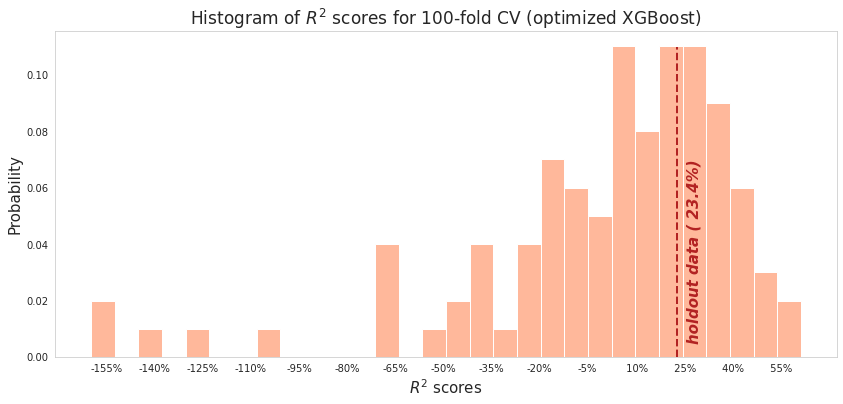

In [274]:
r2_first = np.array(cv_scores)
first_bound = r2_first.min()-0.1
second_bound = r2_first.max()+0.2
x_t_first = np.arange(first_bound, second_bound, 0.15)

fig, ax = plt.subplots(1, 1, figsize=(14, 6))
sns.histplot(r2_first, stat='probability', bins=30, color='lightsalmon')
ax.set_title(f'Histogram of $R^2$ scores for {split}-fold CV (optimized XGBoost)', fontsize=17)

ax.set_xticks(x_t_first)
ax.set_xticklabels([f"{x: .0%}" if x not in [x_t_first[0], x_t_first[-1]] else "" for x in x_t_first])
ax.set_xlabel(r'$R^2$ scores', fontsize=15)
ax.set_ylabel(r'Probability', fontsize=15)

ax.grid(False)

plt.axvline(r2, 0, 0.95, color='firebrick', linewidth=2, linestyle='--')
plt.text(r2+0.03, 0.05*ax.get_ylim()[1], f'holdout data ({r2: .1%})', rotation=90, color='firebrick', 
         fontstyle='oblique', fontweight='heavy', fontsize=15)

plt.savefig('images/XGBoost_Grid.jpg', bbox_inches='tight', dpi=300)
plt.show()


In [279]:
# GRID SEARCH WITH FEATURE ENGINEERING

split = 100

params = {
    "XGB__colsample_bytree": [0.6, 0.8, 1], # default 1
    "XGB__gamma": [0, 0.1, 0.3, 0.5, 1], # default 0, min loss required for partition
    "XGB__learning_rate": [0.1, 0.2, 0.3, 0.6], # default 0.3
    "XGB__max_depth": [1,3,5,7,11, None], # default 3
    "XGB__n_estimators": [100, 150, 200, 400], # default 100
    "XGB__subsample": [0.5, 0.75, 1]  # default 1
    }

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

steps=[('Poly', PolynomialFeatures(degree=4, include_bias=False)), ('Scaler', StandardScaler()),
       ('XGB', xgb.XGBRegressor(n_jobs=-1, objective="reg:squarederror", eval_metric=r2_score))]
# from 5 to 125 features, then X is standardized, then PCA and components are selected such that they explain >0.85 of variance

grid = GridSearchCV(Pipeline(steps), cv=split, param_grid=params, scoring='r2', n_jobs=-1, verbose=0)  
trained = grid.fit(X_train, Y_train.ravel())  

cv_scores = [trained.cv_results_['split' + str(x) + '_test_score'][trained.best_index_] for x in range(split)]
best_score_grid = trained.best_score_
median_r2 = np.median(cv_scores)
assert np.isclose(np.array(cv_scores).mean(), best_score_grid), 'better see'

best_mod = trained.best_estimator_
best_params = trained.best_params_

# holdout
preds =  best_mod.predict(X_test)
r2 = r2_score(Y_test, preds)
rmse = np.sqrt(mean_squared_error(Y_test, preds))

print(f"\n\t AVG. ACROSS {spl} SPLITS (with GridSearch) \n")

print(f"\nParameters chosen for the optimized model: {trained.best_params_}\n")
print(f"Avg. R2 score of optimized model: {trained.best_score_: .5%}")
print(f"Median R2 score of optimized model: {median_r2: .5%}")
print(f"Std. deviation of R2 scores of optimized model: {np.std(cv_scores)}\n")

print(f"\n \t \t HOLDOUT SAMPLE\n")
print(f"R2 score on holdout sample: {r2_score(Y_test, preds): .5%}")
print(f"RMSE score on holdout sample: {np.sqrt(mean_squared_error(Y_test, preds))}\n \n ")


	 AVG. ACROSS 100 SPLITS (with GridSearch) 


Parameters chosen for the optimized model: {'XGB__colsample_bytree': 0.6, 'XGB__gamma': 0, 'XGB__learning_rate': 0.1, 'XGB__max_depth': 1, 'XGB__n_estimators': 100, 'XGB__subsample': 0.5}

Avg. R2 score of optimized model: -1.31532%

Median R2 score of optimized model:  5.69203%
Std. deviation of R2 scores of optimized model: 0.4421812826116019


 	 	 HOLDOUT SAMPLE

R2 score on holdout sample:  29.96972%
RMSE score on holdout sample: 0.014378552498427122
 
 


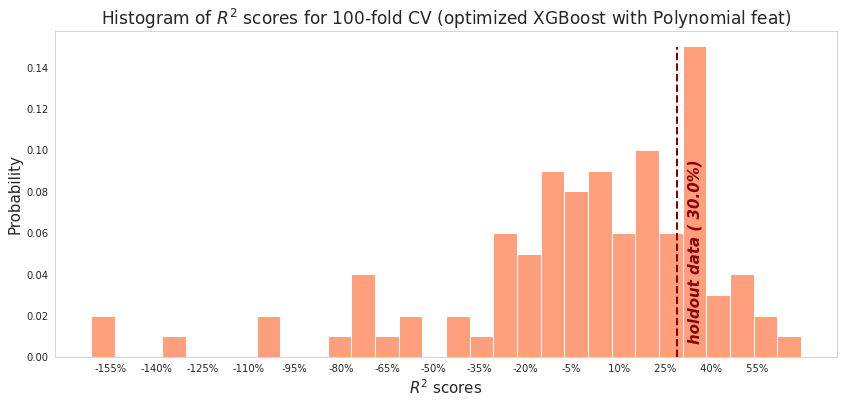

In [286]:
r2_eng = np.array(cv_scores)

first = r2_eng.min() if r2_eng.min()<first_bound else first_bound
second = r2_eng.max() if r2_eng.max()>second_bound else second_bound

x_t = np.arange(first, second, 0.15)

fig, ax = plt.subplots(1, 1, figsize=(14, 6))
sns.histplot(r2_eng, stat='probability', bins=30, color='coral')
ax.set_title(f'Histogram of $R^2$ scores for {split}-fold CV (optimized XGBoost with Polynomial feat)', fontsize=17)

ax.set_xticks(x_t)
ax.set_xticklabels([f"{x: .0%}" if x not in [x_t[0], x_t[-1]] else "" for x in x_t])
ax.set_xlabel(r'$R^2$ scores', fontsize=15)
ax.set_ylabel(r'Probability', fontsize=15)

ax.grid(False)

plt.axvline(r2, 0, 0.95, color='darkred', linewidth=2, linestyle='--')
plt.text(r2+0.034, 0.05*ax.get_ylim()[1], f'holdout data ({r2: .1%})', rotation=90, color='darkred', 
         fontstyle='oblique', fontweight='heavy', fontsize=15)

plt.savefig('images/XGBoost_Polynomial.jpg', bbox_inches='tight', dpi=300)
plt.show()


In [289]:
# GRID SEARCH WITH FEATURE ENGINEERING FROM NEURAL NETWORKS

xgb_model_net = xgb.XGBRegressor(n_jobs=-1, objective="reg:squarederror", eval_metric=r2_score)

params = {
    "colsample_bytree": [0.6, 0.8, 1], # default 1
    "gamma": [0, 0.1, 0.3, 0.5, 1], # default 0, min loss required for partition
    "learning_rate": [0.1, 0.2, 0.3, 0.5], # default 0.3
    "max_depth": [1,3,5,7,11, None], # default 3
    "n_estimators": [100, 150, 200, 400], # default 100
    "subsample": [0.5, 0.75, 1]  # default 1
}

split = 100

X_train_eng, X_test_eng = create_features(X_train, X_test, Y_train, Y_test)

grid = GridSearchCV(estimator=xgb_model_net, cv=split, param_grid=params, scoring='r2', n_jobs=-1, verbose=0)  
trained = grid.fit(X_train_eng, Y_train.ravel())  

cv_scores_net = [trained.cv_results_['split' + str(x) + '_test_score'][trained.best_index_] for x in range(split)]
best_score_grid_net = trained.best_score_
median_r2_net = np.median(cv_scores)
assert np.isclose(np.array(cv_scores_net).mean(), best_score_grid_net), 'better see'

best_mod_net = trained.best_estimator_
best_params_net = trained.best_params_

# holdout
preds =  best_mod_net.predict(X_test_eng)
r2_net = r2_score(Y_test, preds)
rmse_net = np.sqrt(mean_squared_error(Y_test, preds))

print(f"\n\t AVG. ACROSS {spl} SPLITS (with GridSearch) \n")

print(f"\nParameters chosen for the optimized model: \n {best_params_net}\n")
#print(f"Feature importances: \n {best_mod_net.feature_importances_}\n")
print(f"Avg. R2 score of optimized model: {best_score_grid_net: .5%}")
print(f"Median R2 score of optimized model: {median_r2_net: .5%}")
print(f"Std. deviation of R2 scores of optimized model: {np.std(cv_scores_net)}\n")

print(f"\n \t \t HOLDOUT SAMPLE\n")
print(f"R2 score on holdout sample: {r2_net: .5%}")
print(f"RMSE on holdout sample: {rmse_net}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 5)                20        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 first_hidden (Dense)        (None, 30)                180       
                                                                 
 batch_normalization_1 (Batc  (None, 30)               120       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 second_hidden (Dense)       (None, 100)               3

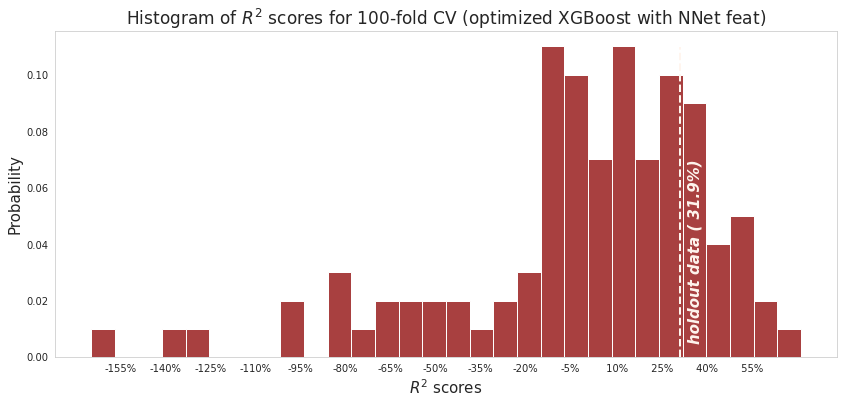

In [296]:
r2_plot = np.array(cv_scores_net)

first = r2_plot.min() if r2_plot.min()<first_bound else first_bound
second = r2_plot.max() if r2_plot.max()>second_bound else second_bound

x_t = np.arange(first, second, 0.15)

fig, ax = plt.subplots(1, 1, figsize=(14, 6))
sns.histplot(r2_plot, stat='probability', bins=30, color='darkred')
ax.set_title(f'Histogram of $R^2$ scores for {split}-fold CV (optimized XGBoost with NNet feat)', fontsize=17)

ax.set_xticks(x_t)
ax.set_xticklabels([f"{x: .0%}" if x not in [x_t[0], x_t[-1]] else "" for x in x_t])
ax.set_xlabel(r'$R^2$ scores', fontsize=15)
ax.set_ylabel(r'Probability', fontsize=15)

ax.grid(False)

plt.axvline(r2_net, 0, 0.95, color='seashell', linewidth=2, linestyle='--')
plt.text(r2_net+0.026, 0.05*ax.get_ylim()[1], f'holdout data ({r2_net: .1%})', rotation=90, color='seashell', 
         fontstyle='oblique', fontweight='heavy', fontsize=15)

plt.savefig('images/XGBoost_NNet.jpg', bbox_inches='tight', dpi=300)
plt.show()


## Neural Nets

In [319]:
# Created new dataset only for Grid, then all models are tested on same Dataset as all previous ones

P=500   
J=5
real_K_=4
MoyLCM=0  
Mass0=1.2   
N_tableaux=400 
T, Types, theta, alpha_proportion, poids_0 = dataset_LCM(P, J, real_K_, MoyLCM, Mass0, N_tableaux)  # random poids in [0, 1]
result, X_sample, Y_sample = preprocess_dataset(T)

print(f"\nMean of Reach across campaigns: {Y_sample.mean(): .5f}\n")

X_train_sample, X_test_sample, Y_train_sample, Y_test_sample = train_test_split(X_sample, Y_sample, train_size=0.8, shuffle=True) # 100 observations in small sample

print(f"Dimension of reduced TRAIN set used for NN tuning: {X_train_sample.shape[0]}")
print(f"Dimension of reduced TEST set used for NN tuning: {X_test_sample.shape[0]}")

[[0.26107232 1.02773923 0.14176015 1.05156742 0.78127387]
 [0.47677413 0.0176073  0.35520077 0.69187831 0.72483902]
 [0.38331376 0.40741455 1.01639795 0.16596463 0.19414129]
 [0.45543654 0.12255678 0.9680686  0.30841155 0.19609577]] are the thresholds for sparsity 

[[1.4176226  2.50111891 2.30290153 3.95805113 3.24782746]
 [0.95457231 0.13939694 0.21221618 0.09631232 0.6182718 ]
 [4.15307437 2.8747938  1.37686152 1.67178681 1.31647392]
 [1.74959807 0.96299165 1.94953254 1.02754926 1.61739127]] are the parameters for the KxJ Poissons 

Execution time for preprocessing the dataset  is  0.0  h : 0.0  m : 1.74  s

Mean of Reach across campaigns:  0.85386

Dimension of reduced TRAIN set used for NN tuning: 320
Dimension of reduced TEST set used for NN tuning: 80


### 1 hidden layer

In [321]:
input_dim = X_train_sample.shape[1]

def create_1hidden_model(batch_norm=False, dropout_rate_init=0, dropout_rate_hidd=0, init_mode='uniform', activ_hidd='relu',
                         activ_out='linear', constraint=5.0, neurons=10, loss_=MeanSquaredError()):
    '''
    feature_outputs is output of above function (dense Tensors)
    '''
    clear_session()
    
    model=Sequential()  #name
    if batch_norm==True:
        model.add(BatchNormalization(input_shape=(input_dim,)))
        model.add(Dropout(dropout_rate_init))
    else: 
        model.add(Dropout(dropout_rate_init, input_shape=(input_dim,)))
    model.add(Dense(neurons, activation=activ_hidd, kernel_initializer=init_mode, name='hidden_layer', kernel_constraint=MaxNorm(constraint)))
    if batch_norm==True:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_rate_hidd))
    model.add(Dense(1, activation=activ_out, kernel_initializer=init_mode, name='output'))
    model.compile(optimizer=RMSprop(momentum=0.9), loss=loss_, metrics=[RSquare(), RootMeanSquaredError()])  # loss_weights = ..., 
    return model

#callbacks = EarlyStopping(monitor='loss', patience=8, restore_best_weights=True, verbose=0)

mpl = KerasRegressor(model=create_1hidden_model, verbose=0)  #callbacks=callbacks

epochs = [60, 120]
lr = [0.001, 0.01, 0.1]
drop_rate_input = [0.1, 0.2]
drop_rate_hidden = [0.1, 0.3, 0.5]
constraint = [1.0, 3.0, 5.0]
init_mode = ['zeros', 'ones', 'he_uniform', 'he_normal']
activ_hidd = ['relu', 'tanh', 'linear', 'sigmoid']
activ_out = ['linear', 'sigmoid']
neurons = [2, 5, 12, 25, 50]

params = dict(batch_size=[32], 
              epochs=epochs, 
              #callbacks__patience=patience, 
              optimizer__learning_rate=lr, 
              #optimizer__momentum=mom, 
              model__batch_norm=[True],
              model__init_mode=init_mode,
              model__dropout_rate_init=drop_rate_input, 
              model__dropout_rate_hidd=drop_rate_hidden, 
              model__activ_hidd=activ_hidd, 
              model__activ_out=activ_out,
              model__constraint=constraint, 
              model__loss_ = [MeanSquaredError()],
              model__neurons=neurons)

cross_split = 3

grid = GridSearchCV(estimator=mpl, param_grid=params, n_jobs=1, cv=cross_split, verbose=1)
trained = grid.fit(X_train_sample, Y_train_sample)

cv_scores = [trained.cv_results_['split' + str(x) + '_test_score'][trained.best_index_] for x in range(cross_split)]
best_score_grid = trained.best_score_
median_r2 = np.median(cv_scores)
assert np.isclose(np.array(cv_scores).mean(), best_score_grid), 'better see'

best_mod = trained.best_estimator_
best_params = trained.best_params_

# holdout
preds =  best_mod.predict(X_test_sample)
r2 = r2_score(Y_test_sample, preds)
rmse = np.sqrt(mean_squared_error(Y_test_sample, preds))
    

Fitting 3 folds for each of 17280 candidates, totalling 51840 fits


In [359]:
print(f"\n\tAVG. ACROSS {cross_split} SPLITS (with GridSearch) \n")

print(f"\nParameters chosen for the optimized model: \n {best_params}\n")
print(f"Avg. R2 score of optimized model: {best_score_grid: .5%}")
print(f"Median R2 score of optimized model: {median_r2: .5%}")
print(f"Std. deviation of R2 scores of optimized model: {np.std(cv_scores)}\n")

print(f"\n \t \t HOLDOUT SAMPLE\n")
print(f"R2 score on holdout sample: {r2: .5%}")
print(f"RMSE on holdout sample: {rmse}\n \n")

print(f"(everything is computed on a reduced dataset of {X_sample.shape[0]} observations)")

to_p = [f"{x: .2%}" for x in cv_scores]
print(f"(the {cross_split} evaluation of the reduced GridSearch are: {to_p})\n\n")


	AVG. ACROSS 3 SPLITS (with GridSearch) 


Parameters chosen for the optimized model: 
 {'batch_size': 32, 'epochs': 120, 'model__activ_hidd': 'tanh', 'model__activ_out': 'sigmoid', 'model__batch_norm': True, 'model__constraint': 1.0, 'model__dropout_rate_hidd': 0.1, 'model__dropout_rate_init': 0.1, 'model__init_mode': 'he_normal', 'model__loss_': <keras.losses.MeanSquaredError object at 0x7fdeecee7f40>, 'model__neurons': 5, 'optimizer__learning_rate': 0.01}

Avg. R2 score of optimized model:  26.54542%
Median R2 score of optimized model:  24.67474%
Std. deviation of R2 scores of optimized model: 0.05060980523683268


 	 	 HOLDOUT SAMPLE

R2 score on holdout sample:  29.07723%
RMSE on holdout sample: 0.013672260064092267
 

(everything is computed on a reduced dataset of 400 observations)
(the 3 evaluation of the reduced GridSearch are: [' 24.67%', ' 33.46%', ' 21.50%'])




In [375]:
# 100-fold Cross-validation with optimized parameter 
# on Entire dataset (1000 observations)

spl = 100
kf = KFold(n_splits=spl, shuffle=True)
chos = list(best_params.items())

r2, rmse = [], []

for idx, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    mod = KerasRegressor(model=create_1hidden_model, batch_size=32, epochs=120,
                     batch_norm = chos[4][1], dropout_rate_init=chos[7][1], dropout_rate_hidd=chos[6][1], 
                     init_mode=chos[8][1], activ_hidd=chos[2][1], activ_out=chos[3][1], constraint=chos[5][1], 
                     neurons = chos[-2][1], loss = chos[-3][1], optimizer__learning_rate=chos[-1][1], verbose=0)
    
    trained = mod.fit(X_train, Y_train)
    preds = trained.predict(X_test)
    
    r2.append(r2_score(Y_test, preds))
    rmse.append(np.sqrt(mean_squared_error(Y_test, preds)))

# averaged score
avg_r2 = np.array(r2).mean()
median_r2 = np.median(r2)

avg_rmse = np.array(rmse).mean()
median_rmse = np.median(rmse)

print(f"\t \t AVG. ACROSS {spl} SPLITS\n")
print(f"Average R2 score on holdout sample: {avg_r2: .5%}")
print(f"Median R2 score on holdout sample: {median_r2: .5%}\n")
print(f"Std. deviation of R2 scores on holdout sample: {np.std(np.array(r2))}\n")

print(f"Average RMSE on holdout sample: {avg_rmse}")
print(f"Median RMSE on holdout sample: {median_rmse}\n\n")


	 	 AVG. ACROSS 100 SPLITS

Average R2 score on holdout sample:  11.64290%
Median R2 score on holdout sample:  29.91180%

Std. deviation of R2 scores on holdout sample: 0.7251366634351605

Average RMSE on holdout sample: 0.015052198227440205
Median RMSE on holdout sample: 0.014981148903426555




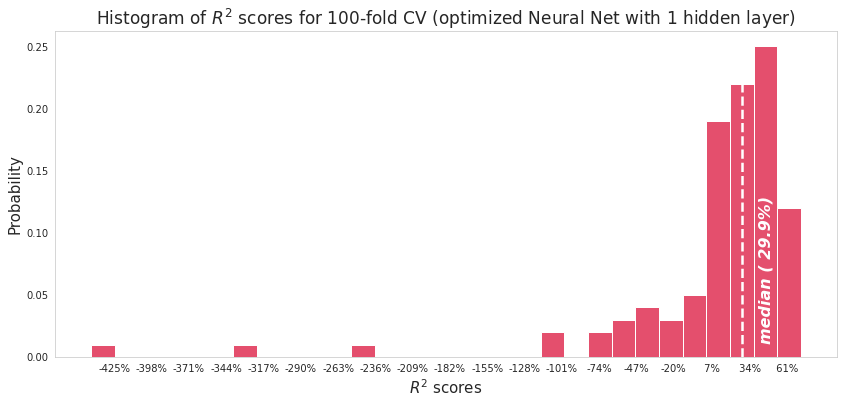

In [412]:
r2_first = np.array(r2)
first_bound = r2_first.min()-0.1
second_bound = r2_first.max()+0.2
x_t_first = np.arange(first_bound, second_bound, 0.27)

fig, ax = plt.subplots(1, 1, figsize=(14, 6))
sns.histplot(r2, stat='probability', bins=30, color='crimson')
ax.set_title(f'Histogram of $R^2$ scores for {spl}-fold CV (optimized Neural Net with 1 hidden layer)', fontsize=17)

ax.set_xticks(x_t_first)
ax.set_xticklabels([f"{x: .0%}" if x not in [x_t_first[0], x_t_first[-1]] else "" for x in x_t_first])
ax.set_xlabel(r'$R^2$ scores', fontsize=15)
ax.set_ylabel(r'Probability', fontsize=15)

ax.grid(False)

plt.axvline(median_r2, 0, 0.95, color='white', linewidth=2.5, linestyle='--')
plt.text(median_r2+0.12, 0.05*ax.get_ylim()[1], f'median ({median_r2: .1%})', rotation=90, color='white', 
         fontstyle='oblique', fontweight='heavy', fontsize=16)

plt.savefig('images/NNEt_1layer.jpg', bbox_inches='tight', dpi=300)
plt.show()

plt.show()


### 2 hidden layers

In [ ]:
def create_2hidden_model(batch_norm=False, dropout_rate_init=0, dropout_rate_hidd=0, init_mode='uniform', activ_hidd='relu',
                         activ_out='linear', constraint=5.0, neurons_1=10, neurons_2=5, loss_=MeanSquaredError()):
    '''
    feature_outputs is output of above function (dense Tensors)
    '''
    clear_session()
    
    model=Sequential()  #name
    if batch_norm==True:
        model.add(BatchNormalization(input_shape=(input_dim,)))
        model.add(Dropout(dropout_rate_init))
    else: 
        model.add(Dropout(dropout_rate_init, input_shape=(input_dim,)))
    model.add(Dense(neurons_1, activation=activ_hidd, kernel_initializer=init_mode, name='hidden_layer_1', kernel_constraint=MaxNorm(constraint)))
    if batch_norm==True:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_rate_hidd))
    model.add(Dense(neurons_2, activation=activ_hidd, kernel_initializer=init_mode, name='hidden_layer_2', kernel_constraint=MaxNorm(constraint)))
    if batch_norm==True:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_rate_hidd))
    model.add(Dense(1, activation=activ_out, kernel_initializer=init_mode, name='output'))
    model.compile(loss=loss_, metrics=[RSquare(), RootMeanSquaredError()])  # loss_weights = ..., 
    return model

call_ = EarlyStopping(monitor='loss', patience=8, restore_best_weights=True, verbose=0)

mpl = KerasRegressor(model=create_2hidden_model, optimizer=Adam(), verbose=0, callbacks=call_)

batch_size = [5, 10, 20, 32, 64, 80, 128]
epochs = [10, 50, 100, 200]
lr = [0.001, 0.01, 0.1, 0.2]
batch_norm = [True,  False]
drop_rate_input = [0.1, 0.2]
drop_rate_hidden = [0.1, 0.2, 0.3, 0.5, 0.6, 0.8]
constraint = [1.0, 3.0, 5.0]
init_mode = ['random_uniform', 'random_normal', 'zeros', 'ones', 'he_uniform', 'he_normal']
activ_hidd = ['relu', 'tanh', 'linear', 'sigmoid']
activ_out = ['linear', 'sigmoid']
neurons_1 = [2, 3, 5, 10, 15, 20, 30, 50, 70]
neurons_2 = [2, 3, 5, 10, 15, 20, 30, 50, 70]
loss_ = [MeanSquaredError(), MeanSquaredLogarithmicError()]

params = dict(batch_size=batch_size, 
              epochs=epochs, 
              optimizer__learning_rate=lr,
              model__batch_norm=batch_norm,
              model__init_mode=init_mode,
              model__dropout_rate_init=drop_rate_input, 
              model__dropout_rate_hidd=drop_rate_hidden, 
              model__activ_hidd=activ_hidd, 
              model__activ_out=activ_out,
              model__constraint=constraint, 
              model__loss_ = loss_,
              model__neurons_1=neurons_1,
              model__neurons_2=neurons_2)

cross_split = 5

grid = GridSearchCV(estimator=mpl, param_grid=params, n_jobs=1, cv=cross_split)
#grid = RandomizedSearchCV(estimator=mpl, param_distributions=params, n_jobs=1, cv=cross_split)
trained = grid.fit(X_train, Y_train)

cv_scores = [trained.cv_results_['split' + str(x) + '_test_score'][trained.best_index_] for x in range(cross_split)]
best_score_grid = trained.best_score_
median_r2 = np.median(cv_scores)
assert np.isclose(np.array(cv_scores).mean(), best_score_grid), 'better see'

best_mod = trained.best_estimator_
best_params = trained.best_params_

# holdout
preds =  best_mod.predict(X_test)
r2 = r2_score(Y_test, preds)
rmse = np.sqrt(mean_squared_error(Y_test, preds))
    

In [ ]:
print(f"\n\tAVG. ACROSS {cross_split} SPLITS (with GridSearch) \n")

print(f"\nParameters chosen for the optimized model: \n {best_params}\n")
print(f"Avg. R2 score of optimized model: {best_score_grid: .5%}")
print(f"Median R2 score of optimized model: {median_r2: .5%}")
print(f"Std. deviation of R2 scores of optimized model: {np.std(cv_scores)}\n")

print(f"\n \t \t HOLDOUT SAMPLE\n")
print(f"R2 score on holdout sample: {r2: .5%}")
print(f"RMSE on holdout sample: {rmse}\n \n")

In [ ]:

r2_cv = np.array(cv_scores)
x_t = np.arange(r2_cv.min()-0.1, r2_cv.max()+0.2, 0.15)

fig, ax = plt.subplots(1, 1, figsize=(14, 6))
sns.histplot(r2_cv, stat='probability', bins=30, color='coral')
ax.set_title(f'Histogram of $R^2$ scores (optimized Neural Net with 1 hidden layer)', fontsize=17)

ax.set_xticks(x_t)
ax.set_xticklabels([f"{x: .0%}" if x not in [x_t[0], x_t[-1]] else "" for x in x_t])
ax.set_xlabel(r'$R^2$ scores', fontsize=15)
ax.set_ylabel(r'Probability', fontsize=15)

ax.grid(False)

plt.axvline(r2, 0, 0.95, color='darkred', linewidth=2, linestyle='--')
plt.text(0.85*r2, 0.05*ax.get_ylim()[1], f'holdout data ({r2: .1%})', rotation=90, color='darkred', 
         fontstyle='oblique', fontweight='heavy', fontsize=15)

# plt.savefig('images/NNEt_2layer.jpg', bbox_inches='tight', dpi=300)
plt.show()


### 3 hidden layers

In [ ]:
def create_3hidden_model(batch_norm=False, dropout_rate_init=0, dropout_rate_hidd=0, init_mode='uniform', activ_hidd='relu',
                         activ_out='linear', constraint=5.0, neurons_1=10, neurons_2=5, neurons_3=2, loss_=MeanSquaredError()):
    '''
    feature_outputs is output of above function (dense Tensors)
    '''
    clear_session()
    
    model=Sequential()  #name
    if batch_norm==True:
        model.add(BatchNormalization(input_shape=(input_dim,)))
        model.add(Dropout(dropout_rate_init))
    else: 
        model.add(Dropout(dropout_rate_init, input_shape=(input_dim,)))
    model.add(Dense(neurons_1, activation=activ_hidd, kernel_initializer=init_mode, name='hidden_layer_1', kernel_constraint=MaxNorm(constraint)))
    if batch_norm==True:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_rate_hidd))
    model.add(Dense(neurons_2, activation=activ_hidd, kernel_initializer=init_mode, name='hidden_layer_2', kernel_constraint=MaxNorm(constraint)))
    if batch_norm==True:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_rate_hidd))
    model.add(Dense(neurons_3, activation=activ_hidd, kernel_initializer=init_mode, name='hidden_layer_3', kernel_constraint=MaxNorm(constraint)))
    if batch_norm==True:
        model.add(BatchNormalization())
    # without final Dropout
    model.add(Dense(1, activation=activ_out, kernel_initializer=init_mode, name='output'))
    model.compile(loss=loss_, metrics=[RSquare(), RootMeanSquaredError()])  # loss_weights = ..., 
    return model

call_ = EarlyStopping(monitor='loss', patience=8, restore_best_weights=True, verbose=0)

mpl = KerasRegressor(model=create_3hidden_model, optimizer=Adam(), verbose=0, callbacks=call_)

batch_size = [10, 32, 64, 128]
epochs = [10, 50, 100]
lr = [0.001, 0.01, 0.1]
batch_norm = [True,  False]
drop_rate_input = [0.1, 0.2]
drop_rate_hidden = [0.2, 0.3, 0.5, 0.6]
constraint = [1.0, 3.0, 5.0]
init_mode = ['random_uniform', 'random_normal', 'zeros', 'ones']   # no he uniform
activ_hidd = ['relu', 'tanh', 'linear', 'sigmoid']
activ_out = ['linear', 'sigmoid']
neurons_1 = [2, 3, 5, 10, 15, 20, 30, 50]
neurons_2 = [2, 3, 5, 10, 15, 20, 30]
neurons_3 = [2, 3, 5, 10, 15, 20]
loss_ = [MeanSquaredError(), MeanSquaredLogarithmicError()]

params = dict(batch_size=batch_size, 
              epochs=epochs, 
              optimizer__learning_rate=lr,
              model__batch_norm=batch_norm,
              model__init_mode=init_mode,
              model__dropout_rate_init=drop_rate_input, 
              model__dropout_rate_hidd=drop_rate_hidden, 
              model__activ_hidd=activ_hidd, 
              model__activ_out=activ_out,
              model__constraint=constraint, 
              model__loss_ = loss_,
              model__neurons_1=neurons_1,
              model__neurons_2=neurons_2,
              model__neurons_3=neurons_3)

cross_split = 5

grid = GridSearchCV(estimator=mpl, param_grid=params, n_jobs=1, cv=cross_split)
trained = grid.fit(X_train, Y_train)

cv_scores = [trained.cv_results_['split' + str(x) + '_test_score'][trained.best_index_] for x in range(cross_split)]
best_score_grid = trained.best_score_
median_r2 = np.median(cv_scores)
assert np.isclose(np.array(cv_scores).mean(), best_score_grid), 'better see'

best_mod = trained.best_estimator_
best_params = trained.best_params_

# holdout
preds =  best_mod.predict(X_test)
r2 = r2_score(Y_test, preds)
rmse = np.sqrt(mean_squared_error(Y_test, preds))
    

In [ ]:
print(f"\n\tAVG. ACROSS {cross_split} SPLITS (with GridSearch) \n")

print(f"\nParameters chosen for the optimized model: \n {best_params}\n")
print(f"Avg. R2 score of optimized model: {best_score_grid: .5%}")
print(f"Median R2 score of optimized model: {median_r2: .5%}")
print(f"Std. deviation of R2 scores of optimized model: {np.std(cv_scores)}\n")

print(f"\n \t \t HOLDOUT SAMPLE\n")
print(f"R2 score on holdout sample: {r2: .5%}")
print(f"RMSE on holdout sample: {rmse}\n \n")

In [ ]:

r2_cv = np.array(cv_scores)
x_t = np.arange(r2_cv.min()-0.1, r2_cv.max()+0.2, 0.15)

fig, ax = plt.subplots(1, 1, figsize=(14, 6))
sns.histplot(r2_cv, stat='probability', bins=30, color='coral')
ax.set_title(f'Histogram of $R^2$ scores (optimized Neural Net with 1 hidden layer)', fontsize=17)

ax.set_xticks(x_t)
ax.set_xticklabels([f"{x: .0%}" if x not in [x_t[0], x_t[-1]] else "" for x in x_t])
ax.set_xlabel(r'$R^2$ scores', fontsize=15)
ax.set_ylabel(r'Probability', fontsize=15)

ax.grid(False)

plt.axvline(r2, 0, 0.95, color='darkred', linewidth=2, linestyle='--')
plt.text(0.85*r2, 0.05*ax.get_ylim()[1], f'holdout data ({r2: .1%})', rotation=90, color='darkred', 
         fontstyle='oblique', fontweight='heavy', fontsize=15)

# plt.savefig('images/NNEt_3layer.jpg', bbox_inches='tight', dpi=300)
plt.show()


7/7 [==============================] - 0s 1ms/step - loss: 3.0006e-04 - root_mean_squared_error: 0.0173

 	 	 HOLDOUT SAMPLE

R2 score on holdout sample:  32.98873%
RMSE score on holdout sample: 0.017322324216365814


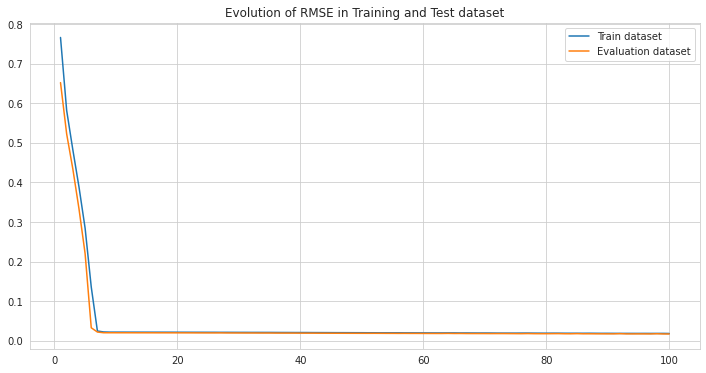

In [33]:
# old plot to use the function, it can be useful

preds_2 = model_2.predict(X_test)
mse_2, rmse_2 = model_2.evaluate(X_test, Y_test)

rmsec_2 = history_2.history['root_mean_squared_error']  # since tracking 'mae'
val_rmse_2 = history_2.history['val_root_mean_squared_error']

print(f"\n \t \t HOLDOUT SAMPLE\n")

print(f"R2 score on holdout sample: {r2_score(Y_test, preds_2): .5%}")
print(f"RMSE score on holdout sample: {rmse_2}")

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
epochs=range(1, len(rmsec_2)+1)
ax.plot(epochs, rmsec_2, label="Train dataset")
ax.plot(epochs, val_rmse_2, label="Evaluation dataset")
ax.set_title("Evolution of RMSE in Training and Test dataset")
plt.legend()
plt.show()